In [16]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import pandas_ta as ta
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, accuracy_score, mean_squared_error
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

# ============================================================================ 
# 1. 날짜 파싱 및 CSV 로드 함수
# ============================================================================ 
def standardize_date_column(df,file_name):
    """날짜 컬럼 자동 탐지 + datetime 통일 + tz 제거 + 시각 제거"""

    date_cols = [col for col in df.columns if 'date' in col.lower()]
    if not date_cols:
        print("[Warning] 날짜 컬럼을 찾을 수 없습니다.")
        return df
    date_col = date_cols[0]
    

    if date_col != 'date':
        df.rename(columns={date_col: 'date'}, inplace=True)
    

    if file_name == 'eth_onchain.csv':
        df['date'] = pd.to_datetime(df['date'], format='%y-%m-%d', errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
    
    #print(df.shape)
    df = df.dropna(subset=['date'])
    #print(df.shape)
    df['date'] = df['date'].dt.normalize()  
    if pd.api.types.is_datetime64tz_dtype(df['date']):
        df['date'] = df['date'].dt.tz_convert(None)
    else:
        df['date'] = df['date'].dt.tz_localize(None)
    #print(df.shape)
    return df

def load_and_standardize_data(filepath):

    df = pd.read_csv(filepath)
    df = standardize_date_column(df,filepath)
    return df
# ============================================================================ 
# 2. 데이터 로딩
# ============================================================================ 
DATA_DIR = './macro_data'

def load_from_macro_data(filename):
    return load_and_standardize_data(os.path.join(DATA_DIR, filename))

macro_df = load_from_macro_data('macro_crypto_data.csv')
news_df = load_from_macro_data('news_data.csv')
eth_onchain_df = load_from_macro_data('eth_onchain.csv')
fear_greed_df = load_from_macro_data('fear_greed.csv')
usdt_eth_mcap_df = load_from_macro_data('usdt_eth_mcap.csv')
aave_tvl_df = load_from_macro_data('aave_eth_tvl.csv')
lido_tvl_df = load_from_macro_data('lido_eth_tvl.csv')
makerdao_tvl_df = load_from_macro_data('makerdao_eth_tvl.csv')
eth_chain_tvl_df = load_from_macro_data('eth_chain_tvl.csv')
eth_funding_df = load_from_macro_data('eth_funding_rate.csv')
sp500_df = load_from_macro_data('SP500.csv')
vix_df = load_from_macro_data('VIX.csv')
gold_df = load_from_macro_data('GOLD.csv')
dxy_df = load_from_macro_data('DXY.csv')

# ============================================================================ 
# 3. 기준 날짜 설정 (Lido TVL 시작일 기준)
# ============================================================================ 
train_start_date = pd.to_datetime('2020-12-19')
lookback_start_date = train_start_date - timedelta(days=200)
end_date= pd.to_datetime('2025-10-06')

# ============================================================================ 
# 4. 뉴스 감성 피처 생성 
# ============================================================================ 
def create_sentiment_features_with_lags(news_df):
    sentiment_agg = news_df.groupby('date').agg(
        sentiment_mean=('label', 'mean'),
        sentiment_std=('label', 'std'),
        news_count=('label', 'count'),
        positive_ratio=('label', lambda x: (x == 1).sum() / len(x)),
        negative_ratio=('label', lambda x: (x == -1).sum() / len(x))
    ).reset_index()
    
    sentiment_agg['sentiment_std'].fillna(0, inplace=True)
    sentiment_agg.drop(['sentiment_mean', 'sentiment_std', 'news_count',
                        'positive_ratio', 'negative_ratio'], axis=1, inplace=True)
    return sentiment_agg

sentiment_features = create_sentiment_features_with_lags(news_df)

# ============================================================================ 
# 5. 데이터 병합
# ============================================================================ 
def add_prefix(df, prefix):
    df.columns = [prefix + '_' + col if col != 'date' else col for col in df.columns]
    return df

eth_onchain_df = add_prefix(eth_onchain_df, 'eth')
fear_greed_df = add_prefix(fear_greed_df, 'fg')
usdt_eth_mcap_df = add_prefix(usdt_eth_mcap_df, 'usdt')
aave_tvl_df = add_prefix(aave_tvl_df, 'aave')
lido_tvl_df = add_prefix(lido_tvl_df, 'lido')
makerdao_tvl_df = add_prefix(makerdao_tvl_df, 'makerdao')
eth_chain_tvl_df = add_prefix(eth_chain_tvl_df, 'chain')
eth_funding_df = add_prefix(eth_funding_df, 'funding')
sp500_df = add_prefix(sp500_df, 'sp500')
vix_df = add_prefix(vix_df, 'vix')
gold_df = add_prefix(gold_df, 'gold')
dxy_df = add_prefix(dxy_df, 'dxy')

date_range = pd.date_range(start=lookback_start_date, end=end_date, freq='D')
df_merged = pd.DataFrame(date_range, columns=['date'])

# List of all dataframes to be merged
dataframes_to_merge = [
    macro_df, sentiment_features, eth_onchain_df, fear_greed_df, usdt_eth_mcap_df,
    aave_tvl_df, lido_tvl_df, makerdao_tvl_df, eth_chain_tvl_df,
    eth_funding_df, sp500_df, vix_df, gold_df, dxy_df
]

# Sequentially merge all dataframes onto the master date range
for df_to_merge in dataframes_to_merge:
    df_merged = pd.merge(df_merged, df_to_merge, on='date', how='left')

# ============================================================================
# 5.1. lookback 기간 동안 모든 값이 결측치인 컬럼 제거
# ============================================================================
# Define the 60-day lookback period
lookback_period_df = df_merged[(df_merged['date'] >= lookback_start_date) & (df_merged['date'] < train_start_date)]

# Find columns where all values in this period are NaN
cols_to_drop = [col for col in lookback_period_df.columns if lookback_period_df[col].isnull().all() and not col.startswith("lido")]

if cols_to_drop:
    print(f"Dropping columns with all NaN values during the lookback period ({lookback_start_date.date()} to {train_start_date.date()}):")
    print(cols_to_drop)
    df_merged.drop(columns=cols_to_drop, inplace=True)
else:
    print("No columns to drop; all columns have at least one value in the lookback period.")

# lookback_start_date 이후만 사용
df_merged = df_merged[df_merged['date'] >= lookback_start_date].reset_index(drop=True)


# 최종 shape 및 날짜 범위 확인
print("최종 데이터 shape:", df_merged.shape)
print("날짜 범위:", df_merged['date'].min(), "~", df_merged['date'].max())

Dropping columns with all NaN values during the lookback period (2020-06-02 to 2020-12-19):
['usdt_totalBridgedToUSD']
최종 데이터 shape: (1953, 70)
날짜 범위: 2020-06-02 00:00:00 ~ 2025-10-06 00:00:00


In [133]:
# 결측치 개수 계산
missing_counts = df_merged.isnull().sum()

# 결측치가 있는 컬럼만 필터링
missing_counts = missing_counts[missing_counts > 0]

if missing_counts.empty:
    print("결측치가 존재하지 않습니다.")
else:
    print("컬럼별 결측치 개수:")
    for col, count in missing_counts.items():
        percent = count / len(df_merged) * 100
        print(f"{col}: {count}개 ({percent:.2f}%)")


컬럼별 결측치 개수:
AVAX_Open: 110개 (5.64%)
AVAX_High: 110개 (5.64%)
AVAX_Low: 110개 (5.64%)
AVAX_Close: 110개 (5.64%)
AVAX_Volume: 110개 (5.64%)
DOT_Open: 79개 (4.05%)
DOT_High: 79개 (4.05%)
DOT_Low: 79개 (4.05%)
DOT_Close: 79개 (4.05%)
DOT_Volume: 79개 (4.05%)
fg_fear_greed: 1개 (0.05%)
lido_lido_eth_tvl: 201개 (10.30%)
sp500_SP500: 608개 (31.16%)
vix_VIX: 608개 (31.16%)
gold_GOLD: 606개 (31.06%)
dxy_DXY: 606개 (31.06%)


In [18]:
# ============================================================================ 
# 추가: 파일별 날짜 범위 확인
# ============================================================================ 
print("\n--- 파일별 날짜 범위 ---")

dataframes_info = [
    ('macro_crypto_data.csv', macro_df),
    ('news_data.csv', news_df),
    ('eth_onchain.csv', eth_onchain_df),
    ('fear_greed.csv', fear_greed_df),
    ('usdt_eth_mcap.csv', usdt_eth_mcap_df),
    ('aave_eth_tvl.csv', aave_tvl_df),
    ('lido_eth_tvl.csv', lido_tvl_df),
    ('makerdao_eth_tvl.csv', makerdao_tvl_df),
    ('eth_chain_tvl.csv', eth_chain_tvl_df),
    ('eth_funding_rate.csv', eth_funding_df),
    ('SP500.csv', sp500_df),
    ('VIX.csv', vix_df),
    ('GOLD.csv', gold_df),
    ('DXY.csv', dxy_df)
]

for name, df in dataframes_info:
    if 'date' in df.columns:
        start_date = df['date'].min().strftime('%Y-%m-%d')
        end_date = df['date'].max().strftime('%Y-%m-%d')
        print(f"**{name.ljust(25)}**: 시작일={start_date}, 종료일={end_date}, 행 수={len(df)}")
    else:
        print(f"**{name.ljust(25)}**: 날짜 컬럼 ('date')을 찾을 수 없습니다.")

print("----------------------\n")


--- 파일별 날짜 범위 ---
**macro_crypto_data.csv    **: 시작일=2017-01-01, 종료일=2025-10-07, 행 수=3201
**news_data.csv            **: 시작일=2020-01-01, 종료일=2025-10-06, 행 수=26005
**eth_onchain.csv          **: 시작일=2015-08-07, 종료일=2025-10-07, 행 수=3715
**fear_greed.csv           **: 시작일=2018-02-01, 종료일=2025-10-07, 행 수=2802
**usdt_eth_mcap.csv        **: 시작일=2017-11-29, 종료일=2025-10-07, 행 수=2870
**aave_eth_tvl.csv         **: 시작일=2020-05-20, 종료일=2025-10-07, 행 수=1968
**lido_eth_tvl.csv         **: 시작일=2020-12-19, 종료일=2025-10-07, 행 수=1754
**makerdao_eth_tvl.csv     **: 시작일=2019-01-04, 종료일=2025-10-07, 행 수=2470
**eth_chain_tvl.csv        **: 시작일=2017-09-27, 종료일=2025-10-07, 행 수=2933
**eth_funding_rate.csv     **: 시작일=2019-11-27, 종료일=2025-10-07, 행 수=2142
**SP500.csv                **: 시작일=2017-01-03, 종료일=2025-10-06, 행 수=2202
**VIX.csv                  **: 시작일=2017-01-03, 종료일=2025-10-06, 행 수=2202
**GOLD.csv                 **: 시작일=2017-01-03, 종료일=2025-10-06, 행 수=2203
**DXY.csv                  **: 시작일=2017-01-0

In [19]:
import pandas as pd
import numpy as np
import pandas_ta as ta

def add_indicator_to_df(df_ta, indicator):
    """pandas_ta 지표 결과를 DataFrame에 안전하게 추가"""
    if indicator is None:
        return

    if isinstance(indicator, pd.DataFrame) and not indicator.empty:
        for col in indicator.columns:
            df_ta[col] = indicator[col]
    elif isinstance(indicator, pd.Series) and not indicator.empty:
        colname = indicator.name if indicator.name else 'Unnamed'
        df_ta[colname] = indicator

def safe_add(df_ta, func, *args, **kwargs):
    """지표 생성 시 오류 방지를 위한 래퍼 함수"""
    try:
        result = func(*args, **kwargs)
        add_indicator_to_df(df_ta, result)
        return True
    except Exception as e:
        func_name = func.__name__ if hasattr(func, '__name__') else str(func)
        print(f"    ⚠ {func_name.upper()} 생성 실패: {str(e)[:50]}")
        return False

def calculate_technical_indicators(df):
    """
    최적화된 기술적 지표 생성 (논문 기반 2024-2025)
    출처: 
    - "CryptoPulse: Short-Term Cryptocurrency Forecasting" (2024)
    - "Enhancing Price Prediction in Cryptocurrency Using Transformer" (2024)
    - "Bitcoin Trend Prediction with Attention-Based Deep Learning" (2024)
    """
    print("\n=== 기술적 지표 생성 중 ===")
    df = df.sort_values('date').reset_index(drop=True)
    df_ta = df.copy()

    close = df['ETH_Close']
    high = df.get('ETH_High', close)
    low = df.get('ETH_Low', close)
    volume = df.get('ETH_Volume', pd.Series(index=df.index, data=1))
    open_ = df.get('ETH_Open', close)

    try:
        # ===== [핵심] MOMENTUM INDICATORS =====
        print("  - Momentum 지표 생성 중...")
        
        # RSI (필수! - 92.4% accuracy 달성)
        df_ta['RSI_14'] = ta.rsi(close, length=14)
        df_ta['RSI_30'] = ta.rsi(close, length=30)
        df_ta['RSI_200'] = ta.rsi(close, length=200)  # 장기 RSI 추가
        
        # MACD (필수! - top feature importance)
        safe_add(df_ta, ta.macd, close, fast=12, slow=26, signal=9)
        
        # Stochastic Oscillator (%K, %D - 논문에서 핵심 지표)
        safe_add(df_ta, ta.stoch, high, low, close, k=14, d=3)
        safe_add(df_ta, ta.stoch, high, low, close, k=30, d=3)  # 30일 추가
        safe_add(df_ta, ta.stoch, high, low, close, k=200, d=3)  # 200일 추가
        
        # Williams %R
        df_ta['WILLR_14'] = ta.willr(high, low, close, length=14)
        
        # ROC (Rate of Change)
        df_ta['ROC_10'] = ta.roc(close, length=10)
        df_ta['ROC_20'] = ta.roc(close, length=20)
        
        # MOM (Momentum - 다양한 기간)
        df_ta['MOM_10'] = ta.mom(close, length=10)
        df_ta['MOM_30'] = ta.mom(close, length=30)  # 추가
        
        # CCI (Commodity Channel Index)
        df_ta['CCI_20'] = ta.cci(high, low, close, length=20)
      
        # TSI (True Strength Index)
        safe_add(df_ta, ta.tsi, close, fast=13, slow=25, signal=13)
        
        # UO (Ultimate Oscillator)
        try:
            df_ta['UO_7_14_28'] = ta.uo(high, low, close)
        except:
            pass
        
        # KST Oscillator
        safe_add(df_ta, ta.kst, close)
        
        # =====  Ichimoku Cloud (암호화폐 트렌드 분석에 효과적) =====
        try:
            ichimoku = ta.ichimoku(high, low, close)
            if ichimoku is not None and isinstance(ichimoku, tuple):
                ichimoku_df = ichimoku[0]
                if ichimoku_df is not None:
                    for col in ichimoku_df.columns:
                        df_ta[col] = ichimoku_df[col]
        except Exception as e:
            print(f"    ⚠ ICHIMOKU 생성 실패")

        # ===== [핵심] OVERLAP INDICATORS =====
        print("  - Overlap 지표 생성 중...")
        
        # SMA (필수! - Golden/Death Cross)
        df_ta['SMA_10'] = ta.sma(close, length=10)
        df_ta['SMA_20'] = ta.sma(close, length=20)
        df_ta['SMA_50'] = ta.sma(close, length=50)
        df_ta['SMA_200'] = ta.sma(close, length=200)
        
        # EMA (필수!)
        df_ta['EMA_12'] = ta.ema(close, length=12)
        df_ta['EMA_26'] = ta.ema(close, length=26)
        df_ta['EMA_50'] = ta.ema(close, length=50)
        df_ta['EMA_200'] = ta.ema(close, length=200)  # 추가
        
        # TEMA (Triple EMA - 논문에서 high importance)
        df_ta['TEMA_10'] = ta.tema(close, length=10)
        df_ta['TEMA_30'] = ta.tema(close, length=30)  # 추가
        
        # WMA (Weighted Moving Average)
        df_ta['WMA_10'] = ta.wma(close, length=10)
        df_ta['WMA_20'] = ta.wma(close, length=20)  # 추가
        
        # HMA (Hull Moving Average)
        df_ta['HMA_9'] = ta.hma(close, length=9)
        
        # DEMA (Double EMA)
        df_ta['DEMA_10'] = ta.dema(close, length=10)
        
        # TRIMA
        df_ta['TRIMA_10'] = ta.trima(close, length=10)
        
        # VWMA (Volume Weighted)
        df_ta['VWMA_20'] = ta.vwma(close, volume, length=20)
        
        # ZLMA (Zero Lag MA)
        safe_add(df_ta, ta.zlma, close, length=20)
        
        # 가격 조합
        df_ta['HL2'] = ta.hl2(high, low)
        df_ta['HLC3'] = ta.hlc3(high, low, close)
        df_ta['OHLC4'] = ta.ohlc4(open_, high, low, close)

        # ===== [핵심] VOLATILITY INDICATORS =====
        print("  - Volatility 지표 생성 중...")
        
        # Bollinger Bands (필수! - 다양한 기간)
        safe_add(df_ta, ta.bbands, close, length=20, std=2)
        safe_add(df_ta, ta.bbands, close, length=50, std=2)  # 50일 추가
        
        # ATR (필수!)
        df_ta['ATR_7'] = ta.atr(high, low, close, length=7)
        df_ta['ATR_14'] = ta.atr(high, low, close, length=14)
        df_ta['ATR_21'] = ta.atr(high, low, close, length=21)  # 추가
        
        # NATR (Normalized ATR)
        df_ta['NATR_14'] = ta.natr(high, low, close, length=14)
        
        # True Range
        try:
            tr = ta.true_range(high, low, close)
            if isinstance(tr, pd.Series) and not tr.empty:
                df_ta['TRUERANGE'] = tr
            elif isinstance(tr, pd.DataFrame) and not tr.empty:
                df_ta['TRUERANGE'] = tr.iloc[:, 0]
        except:
            pass
        
        # Keltner Channel
        safe_add(df_ta, ta.kc, high, low, close, length=20)
        
        # Donchian Channel (안전하게 처리)
        try:
            dc = ta.donchian(high, low, lower_length=20, upper_length=20)
            if dc is not None and isinstance(dc, pd.DataFrame) and not dc.empty:
                for col in dc.columns:
                    df_ta[col] = dc[col]
        except:
            pass
        
        # MASSI (Mass Index)
        try:
            massi = ta.massi(high, low)
            if isinstance(massi, pd.Series) and not massi.empty:
                df_ta['MASSI_9_25'] = massi
        except:
            pass

        # ===== [핵심] VOLUME INDICATORS =====
        print("  - Volume 지표 생성 중...")
        
        # OBV (필수! - On-Balance Volume)
        df_ta['OBV'] = ta.obv(close, volume)
        
        # AD (Accumulation/Distribution)
        df_ta['AD'] = ta.ad(high, low, close, volume)
        
        # ADOSC
        df_ta['ADOSC_3_10'] = ta.adosc(high, low, close, volume, fast=3, slow=10)
        
        # MFI (Money Flow Index)
        df_ta['MFI_14'] = ta.mfi(high, low, close, volume, length=14)
        
        # CMF (Chaikin Money Flow - 논문에서 중요 지표)
        df_ta['CMF_20'] = ta.cmf(high, low, close, volume, length=20)
        
        # EFI (Elder Force Index)
        df_ta['EFI_13'] = ta.efi(close, volume, length=13)
        
        # EOM (Ease of Movement)
        safe_add(df_ta, ta.eom, high, low, close, volume, length=14)
        
        # NVI/PVI
        safe_add(df_ta, ta.nvi, close, volume)
        safe_add(df_ta, ta.pvi, close, volume)
        
        # PVT (Price Volume Trend)
        df_ta['PVT'] = ta.pvt(close, volume)
        
        # VWAP (Volume Weighted Average Price) - 추가
        try:
            df_ta['VWAP'] = ta.vwap(high, low, close, volume)
        except:
            pass

        # ===== [핵심] TREND INDICATORS =====
        print("  - Trend 지표 생성 중...")
        
        # ADX (필수! - Average Directional Index)
        safe_add(df_ta, ta.adx, high, low, close, length=14)
        
        # Aroon (안전하게 처리)
        try:
            aroon = ta.aroon(high, low, length=25)
            if aroon is not None and isinstance(aroon, pd.DataFrame):
                for col in aroon.columns:
                    df_ta[col] = aroon[col]
        except:
            pass
        
        # PSAR (Parabolic SAR - 안전하게 처리)
        try:
            psar = ta.psar(high, low, close)
            if psar is not None:
                if isinstance(psar, pd.DataFrame) and not psar.empty:
                    for col in psar.columns:
                        df_ta[col] = psar[col]
                elif isinstance(psar, pd.Series) and not psar.empty:
                    df_ta[psar.name] = psar
        except:
            pass
        
        # Vortex
        safe_add(df_ta, ta.vortex, high, low, close, length=14)
        
        # QStick
        safe_add(df_ta, ta.qstick, open_, close, length=14)
        
        # DPO (Detrended Price Oscillator) - 추가
        try:
            df_ta['DPO_20'] = ta.dpo(close, length=20)
        except:
            pass

        # ===== [추가] 파생 지표 (논문 검증) =====
        print("  - 파생 지표 생성 중...")
        
        # 가격 변화율 (다양한 기간)
        df_ta['PRICE_CHANGE'] = close.pct_change()
        df_ta['PRICE_CHANGE_2'] = close.pct_change(periods=2)
        df_ta['PRICE_CHANGE_5'] = close.pct_change(periods=5)
        df_ta['PRICE_CHANGE_10'] = close.pct_change(periods=10)  # 추가
        
        # 변동성 (Rolling Std)
        df_ta['VOLATILITY_5'] = close.pct_change().rolling(window=5).std()
        df_ta['VOLATILITY_10'] = close.pct_change().rolling(window=10).std()
        df_ta['VOLATILITY_20'] = close.pct_change().rolling(window=20).std()
        df_ta['VOLATILITY_30'] = close.pct_change().rolling(window=30).std()  # 추가
        
        # 모멘텀 (Price Ratio)
        df_ta['MOMENTUM_5'] = close / close.shift(5) - 1
        df_ta['MOMENTUM_10'] = close / close.shift(10) - 1
        df_ta['MOMENTUM_20'] = close / close.shift(20) - 1
        df_ta['MOMENTUM_30'] = close / close.shift(30) - 1  # 추가
        
        # 이동평균 대비 위치 (필수! - high feature importance)
        df_ta['PRICE_VS_SMA10'] = close / df_ta['SMA_10'] - 1
        df_ta['PRICE_VS_SMA20'] = close / df_ta['SMA_20'] - 1
        df_ta['PRICE_VS_SMA50'] = close / df_ta['SMA_50'] - 1
        df_ta['PRICE_VS_SMA200'] = close / df_ta['SMA_200'] - 1
        df_ta['PRICE_VS_EMA12'] = close / df_ta['EMA_12'] - 1  # 추가
        df_ta['PRICE_VS_EMA26'] = close / df_ta['EMA_26'] - 1  # 추가
        
        # 크로스 신호 (Golden/Death Cross)
        df_ta['SMA_CROSS_SIGNAL'] = (df_ta['SMA_10'] > df_ta['SMA_20']).astype(int)
        df_ta['SMA_GOLDEN_CROSS'] = (df_ta['SMA_50'] > df_ta['SMA_200']).astype(int)  # 추가
        df_ta['EMA_CROSS_SIGNAL'] = (df_ta['EMA_12'] > df_ta['EMA_26']).astype(int)
        
        # 거래량 지표
        df_ta['VOLUME_SMA_20'] = ta.sma(volume, length=20)
        df_ta['VOLUME_RATIO'] = volume / (df_ta['VOLUME_SMA_20'] + 1e-10)
        df_ta['VOLUME_CHANGE'] = volume.pct_change()
        df_ta['VOLUME_CHANGE_5'] = volume.pct_change(periods=5)  # 추가
        
        # Range 지표
        df_ta['HIGH_LOW_RANGE'] = (high - low) / (close + 1e-10)
        df_ta['HIGH_CLOSE_RANGE'] = np.abs(high - close.shift()) / (close + 1e-10)
        df_ta['CLOSE_LOW_RANGE'] = (close - low) / (close + 1e-10)
        
        # 일중 가격 위치 (Intraday Position)
        df_ta['INTRADAY_POSITION'] = (close - low) / ((high - low) + 1e-10)  # 추가
        
        # Linear Regression Slope
        try:
            df_ta['SLOPE_5'] = ta.linreg(close, length=5, slope=True)
            df_ta['SLOPE_10'] = ta.linreg(close, length=10, slope=True)
            df_ta['LINREG_14'] = ta.linreg(close, length=14)
        except:
            # 자체 구현
            df_ta['SLOPE_5'] = close.rolling(window=5).apply(
                lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) == 5 else np.nan, raw=True
            )
            df_ta['SLOPE_10'] = close.rolling(window=10).apply(
                lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) == 10 else np.nan, raw=True
            )
        
        # Increasing/Decreasing 신호
        df_ta['INC_1'] = (close > close.shift(1)).astype(int)
        df_ta['DEC_1'] = (close < close.shift(1)).astype(int)
        df_ta['INC_3'] = (close > close.shift(3)).astype(int)
        df_ta['INC_5'] = (close > close.shift(5)).astype(int)  # 추가
        
        # BOP (Balance of Power)
        df_ta['BOP'] = (close - open_) / ((high - low) + 1e-10)
        df_ta['BOP'] = df_ta['BOP'].fillna(0)
        
        # ===== [추가] 고급 파생 지표 =====
        print("  - 고급 파생 지표 생성 중...")
        
        # Bollinger Bands 관련 파생
        if 'BBL_20_2.0' in df_ta.columns and 'BBU_20_2.0' in df_ta.columns:
            df_ta['BB_WIDTH'] = (df_ta['BBU_20_2.0'] - df_ta['BBL_20_2.0']) / df_ta['BBM_20_2.0']
            df_ta['BB_POSITION'] = (close - df_ta['BBL_20_2.0']) / (df_ta['BBU_20_2.0'] - df_ta['BBL_20_2.0'])
        
        # RSI 파생 (Overbought/Oversold)
        df_ta['RSI_OVERBOUGHT'] = (df_ta['RSI_14'] > 70).astype(int)
        df_ta['RSI_OVERSOLD'] = (df_ta['RSI_14'] < 30).astype(int)
        
        # MACD 히스토그램 변화율
        if 'MACDh_12_26_9' in df_ta.columns:
            df_ta['MACD_HIST_CHANGE'] = df_ta['MACDh_12_26_9'].diff()
        
        # Volume Profile (상대적 거래량 강도)
        df_ta['VOLUME_STRENGTH'] = volume / volume.rolling(window=50).mean()
        
        # Price Acceleration (2차 미분)
        df_ta['PRICE_ACCELERATION'] = close.pct_change().diff()
        
        # Gap (시가-전일종가)
        df_ta['GAP'] = (open_ - close.shift(1)) / (close.shift(1) + 1e-10)
        
        # 추가 통계 지표
        df_ta['ROLLING_MAX_20'] = close.rolling(window=20).max()
        df_ta['ROLLING_MIN_20'] = close.rolling(window=20).min()
        df_ta['DISTANCE_FROM_HIGH'] = (df_ta['ROLLING_MAX_20'] - close) / (df_ta['ROLLING_MAX_20'] + 1e-10)
        df_ta['DISTANCE_FROM_LOW'] = (close - df_ta['ROLLING_MIN_20']) / (close + 1e-10)

        added = df_ta.shape[1] - df.shape[1]
        print(f"\n✓ 기술적 지표 생성 완료: {added}개 추가")
        print(f"  총 컬럼 수: {df_ta.shape[1]}")
                
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

    return df_ta



def add_pairwise_correlation_features(df, window_sizes=[7, 14, 30]):
    """
    BTC와 ETH 간의 이동 상관관계 피처 추가.
    df에는 ETH_Close, BTC_Close 컬럼이 있어야 함.
    """
    df2 = df.copy()
    for w in window_sizes:
        col = f"corr_ETH_BTC_{w}"
        df2[col] = df2['ETH_Close'].pct_change().rolling(window=w).corr(
            df2['BTC_Close'].pct_change()
        )
    return df2

def add_volatility_correlation(df, window_sizes=[14, 30]):
    """
    BTC와 ETH 간의 변동성 (예: 절대 수익률 또는 제곱 수익률) 상관관계 추가
    """
    df2 = df.copy()
    # 예: 절대 수익률 또는 제곱 수익률
    ret_eth = df2['ETH_Close'].pct_change()
    ret_btc = df2['BTC_Close'].pct_change()
    abs_eth = ret_eth.abs()
    abs_btc = ret_btc.abs()
    for w in window_sizes:
        df2[f"volcorr_abs_{w}"] = abs_eth.rolling(w).corr(abs_btc)
        df2[f"volcorr_sq_{w}"] = (ret_eth**2).rolling(w).corr(ret_btc**2)
    return df2

def add_granger_causality_features(df, maxlag=5):
    """
    BTC → ETH, ETH → BTC 방향의 그레인지 인과성 유의성 p-value 등을 특징으로 추가
    (주의: 계산 비용 큼)
    """
    df2 = df.copy()
    # 수익률 시리즈
    ret_eth = df2['ETH_Close'].pct_change().dropna()
    ret_btc = df2['BTC_Close'].pct_change().dropna()

    # 합쳐서 DataFrame
    tmp = pd.concat([ret_eth, ret_btc], axis=1).dropna()
    tmp.columns = ['eth_ret', 'btc_ret']

    # granger tests
    gc = grangercausalitytests(tmp[['eth_ret', 'btc_ret']], maxlag=maxlag, verbose=False)
    # 예: eth_ret이 btc_ret을 설명하는 lag p-value (BTC → ETH 방향)
    for lag in range(1, maxlag + 1):
        p_val = gc[lag][0]['ssr_ftest'][1]
        df2.loc[:, f"p_btc_to_eth_lag{lag}"] = p_val
    # 반대 방향
    gc2 = grangercausalitytests(tmp[['btc_ret', 'eth_ret']], maxlag=maxlag, verbose=False)
    for lag in range(1, maxlag + 1):
        p_val = gc2[lag][0]['ssr_ftest'][1]
        df2.loc[:, f"p_eth_to_btc_lag{lag}"] = p_val

    return df2

def add_var_impulse_response_features(df, lags=5, irf_steps=3):
    """
    VAR 모델을 통해 BTC/ETH 간의 충격 반응 (impulse-response) 계수를 피처로 추가.
    (이 기능은 계산 비용이 있고 sample이 충분히 커야 안정됨)
    """
    df2 = df.copy()
    # 수익률 시리즈만 쓰기
    tmp = df2[['ETH_Close', 'BTC_Close']].pct_change().dropna()
    model = VAR(tmp)
    try:
        res = model.fit(lags)
        irf = res.irf(irf_steps)
        # ex: 충격이 BTC에 가해졌을 때 ETH의 반응 등
        for i in range(1, irf_steps + 1):
            # shock to BTC → response in ETH
            val = irf.irfs[i][1, 0]  # 이더리움(1번 idx)이 비트코인 충격(0번 idx)에 대해 반응
            df2.loc[:, f"irf_eth_from_btc_step{i}"] = val
            # 반대 방향: shock ETH → response BTC
            val2 = irf.irfs[i][0, 1]
            df2.loc[:, f"irf_btc_from_eth_step{i}"] = val2
    except Exception as e:
        print("VAR/IRF 계산 실패:", e)
    return df2


In [24]:
# ============================================================================
# 2. Lag 적용
# ============================================================================
def apply_lag_features(df, news_lag=2, onchain_lag=1):
    """논문 기반 lag 적용"""
    print("\n=== Lag 피처 적용 중 ===")
    
    df_lagged = df.copy()
    
    # 뉴스/감성 (2일 lag)
    news_cols = [col for col in df.columns if any(keyword in col.lower() 
                 for keyword in ['sentiment', 'news', 'fear', 'greed', 'fg_'])]
    
    # 온체인 (1일 lag)
    onchain_cols = [col for col in df.columns if any(keyword in col.lower() 
                    for keyword in ['eth_', 'active', 'transaction', 'hash'])]
    
    # TVL/펀딩/거시경제 (1일 lag)
    other_cols = [col for col in df.columns if any(keyword in col.lower() 
                  for keyword in ['tvl', 'funding', 'lido', 'aave', 'makerdao', 
                                'chain_', 'usdt', 'sp500', 'vix', 'gold', 'dxy'])]
    
    # 가격 관련 제외
    exclude_cols = ['date', 'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Volume', 
                   'ETH_Open', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Volume']
    
    lag_count = 0
    
    # 뉴스 lag (1-2일)
    for col in news_cols:
        if col not in exclude_cols:
            for lag in range(1, news_lag + 1):
                df_lagged[f"{col}_lag{lag}"] = df[col].shift(lag)
                lag_count += 1
    
    # 온체인 lag (1일)
    for col in onchain_cols:
        if col not in exclude_cols:
            df_lagged[f"{col}_lag1"] = df[col].shift(onchain_lag)
            lag_count += 1
    
    # 기타 외부 변수 lag (1일)
    for col in other_cols:
        if col not in exclude_cols:
            df_lagged[f"{col}_lag1"] = df[col].shift(1)
            lag_count += 1
    
    print(f"✓ Lag 피처 추가 완료: {lag_count}개 추가")
    print(f"  총 컬럼 수: {df_lagged.shape[1]}")
    
    return df_lagged

def add_price_lag_features_first(df):
    """
    과거 가격을 피처로 추가 (기술적 지표보다 먼저!)
    """
    print("\n=== [STEP 0] 과거 가격 피처 추가 ===")
    
    df_new = df.copy()
    close = df['ETH_Close']
    high = df['ETH_High']
    low = df['ETH_Low']
    volume = df['ETH_Volume']
    
    # 과거 종가 (핵심!)
    for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
        df_new[f'close_lag{lag}'] = close.shift(lag)
    
    # 과거 고가/저가
    for lag in [1, 2, 3, 5, 7]:
        df_new[f'high_lag{lag}'] = high.shift(lag)
        df_new[f'low_lag{lag}'] = low.shift(lag)
    
    # 과거 거래량
    for lag in [1, 2, 3, 5, 7]:
        df_new[f'volume_lag{lag}'] = volume.shift(lag)
    
    # 과거 수익률
    for lag in [1, 2, 3, 5, 7]:
        df_new[f'return_lag{lag}'] = close.pct_change(periods=lag).shift(1)
    
    # 과거 가격 비율
    for lag in [1, 7, 30]:
        df_new[f'close_ratio_lag{lag}'] = close / close.shift(lag)
    
    added = df_new.shape[1] - df.shape[1]
    print(f"  ✓ 추가된 과거 가격 피처: {added}개")
    
    return df_new

# ============================================================================
# 3. 타겟 변수 생성
# ============================================================================
def create_targets(df):
    """타겟 변수 생성"""
    print("\n=== 타겟 변수 생성 ===")
    
    df_target = df.copy()
    close = df['ETH_Close']

    # 내일 종가
    next_close = close.shift(-1)
    
    # 오늘 → 내일 로그 수익률
    df_target['next_log_return'] = np.log(next_close / close)
    
    # 오늘 → 내일 방향성
    df_target['next_direction'] = (next_close > close).astype(int)
    
    # 참고: 내일 실제 종가
    df_target['next_close'] = next_close
    
    print("✓ 타겟 변수 생성 완료")
    print(f"  - next_log_return: log(P(t+1) / P(t))")
    print(f"  - next_direction: P(t+1) > P(t)")
    
    # 확인
    print(f"\n  검증:")
    print(f"  오늘 종가 평균: {close.mean():.2f}")
    print(f"  내일 종가 평균: {next_close.mean():.2f}")
    print(f"  로그 수익률 평균: {df_target['next_log_return'].mean():.6f}")
    print(f"  상승 비율: {df_target['next_direction'].mean():.2%}")
    
    return df_target

# ============================================================================
# 4. Train-Val-Test 분할
# ============================================================================
def split_train_val_test(df, train_start_date, train_ratio=0.7, val_ratio=0.15):
    """시계열 기반 데이터 분할"""
    print("\n=== Train-Val-Test 분할 ===")
    
    df_train_period = df[df['date'] >= train_start_date].copy()
    df_clean = df_train_period.dropna(subset=['next_log_return', 'next_direction','next_close'])
    
    print(f"결측치 제거 후: {len(df_clean)} samples")
    print(f"기간: {df_clean['date'].min()} ~ {df_clean['date'].max()}")
    
    n = len(df_clean)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train_df = df_clean.iloc[:train_end].copy()
    val_df = df_clean.iloc[train_end:val_end].copy()
    test_df = df_clean.iloc[val_end:].copy()
    
    print(f"Train: {len(train_df)} ({train_df['date'].min()} ~ {train_df['date'].max()})")
    print(f"Val: {len(val_df)} ({val_df['date'].min()} ~ {val_df['date'].max()})")
    print(f"Test: {len(test_df)} ({test_df['date'].min()} ~ {test_df['date'].max()})")
    
    return train_df, val_df, test_df



# ============================================================================
# 5. 결측치 처리 
# ============================================================================
def handle_missing_values_paper_based(df, train_start_date):
    """
    암호화폐 시계열 결측치 처리 (논문 기반)
    
    참고문헌:
    1. "Quantifying Cryptocurrency Unpredictability" (2025)
       - 암호화폐는 브라운 운동과 유사, 복잡한 전처리 불필요
       - 원본 데이터 최대한 보존
    
    2. "Time Series Data Forecasting" - 시계열 결측치 처리 원칙
       - Forward fill: 과거→현재만 (데이터 누수 방지)
       - 기술적 지표 초기값: 자연스러운 결측 (유지)
    
    처리 원칙:
    - Train 시작 이전 데이터만 lookback으로 사용
    - 미래 정보 누수 차단
    - 최소한의 개입
    """
    print("\n=== 결측치 처리 (논문 기반) ===")
    
    df_processed = df.copy()
    initial_shape = df_processed.shape
    
    # 1. 기술적 지표 결측치 (자연적 발생 - 유지)
    tech_cols = [col for col in df.columns if any(x in col for x in 
                ['RSI', 'MACD', 'SMA', 'EMA', 'WMA', 'HMA', 'ATR', 'BBL', 'BBM', 'BBU',
                 'WILLR', 'ROC', 'MOM', 'CCI', 'STOCH', 'ADX', 'AROON', 'TSI', 'UO',
                 'FISHER', 'KST', 'VWMA', 'ZLMA', 'NATR', 'UI', 'MASSI', 'CHOP'])]
    
    tech_missing_before = df_processed[tech_cols].isnull().sum().sum() if tech_cols else 0
    print(f"기술적 지표 결측치: {tech_missing_before:,}개 (초기 계산 기간, 유지)")
    
    # 2. 외부 변수 결측치 (Forward Fill만 사용)
    external_cols = [col for col in df.columns if any(x in col for x in 
                    ['eth_', 'fg_', 'usdt_', 'aave_', 'lido_', 'makerdao_',
                     'chain_', 'funding_', 'sp500_', 'vix_', 'gold_', 'dxy_'])]
    
    if external_cols:
        ext_missing_before = df_processed[external_cols].isnull().sum().sum()
        df_processed[external_cols] = df_processed[external_cols].fillna(method='ffill')
        ext_missing_after = df_processed[external_cols].isnull().sum().sum()
        filled = ext_missing_before - ext_missing_after
        print(f"외부 변수 결측치: {ext_missing_before:,}개 → {ext_missing_after:,}개 (forward fill: {filled:,}개)")
    
    # 3. Lag 피처 결측치 (자연적 발생 - 유지)
    lag_cols = [col for col in df.columns if '_lag' in col]
    lag_missing = df_processed[lag_cols].isnull().sum().sum() if lag_cols else 0
    print(f"Lag 피처 결측치: {lag_missing:,}개 (초기 lag 기간, 유지)")
    
    # 4. 가격 데이터 결측치 확인 (있으면 안됨)
    price_cols = ['ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Volume', 'ETH_Open']
    price_missing = df_processed[price_cols].isnull().sum().sum()
    if price_missing > 0:
        print(f"[경고] 가격 데이터 결측치 발견: {price_missing}개")
    
    # 5. Lookback Period 제거
    before_count = len(df_processed)
    df_processed = df_processed[df_processed['date'] >= train_start_date].reset_index(drop=True)
    removed = before_count - len(df_processed)
    print(f"Lookback period 제거: {removed}행 (학습 시작: {train_start_date.date()})")
    
    # 6. 최종 통계
    total_missing = df_processed.isnull().sum().sum()
    total_cells = df_processed.shape[0] * df_processed.shape[1]
    missing_pct = (total_missing / total_cells) * 100
    
    print(f"\n최종 결측치 현황:")
    print(f"  전체: {total_missing:,}/{total_cells:,}개 ({missing_pct:.2f}%)")
    print(f"  Shape: {initial_shape} → {df_processed.shape}")
    print(f"  기간: {df_processed['date'].min().date()} ~ {df_processed['date'].max().date()}")
    
    # 7. 높은 결측치 비율 컬럼 확인 (20% 이상)
    col_missing_pct = (df_processed.isnull().sum() / len(df_processed) * 100).sort_values(ascending=False)
    high_missing = col_missing_pct[col_missing_pct > 20]
    
    if len(high_missing) > 0:
        print(f"\n결측치 20% 이상 컬럼 ({len(high_missing)}개):")
        for col, pct in high_missing.head(10).items():
            print(f"  {col}: {pct:.1f}%")
    
    return df_processed


# ============================================================================
# 6. 스케일링 (Train 기준, 데이터 누수 방지)
# ============================================================================
def scale_features_safe(train_df, val_df, test_df):
    """
    논문 원칙: Train 데이터로만 scaler 학습
    - Val/Test는 Train 통계로 변환
    - RobustScaler: 이상치에 강건
    """
    print("\n=== 스케일링 (Train 기준) ===")
    
    exclude_cols = ['date', 'next_log_return', 'next_direction', 'next_close',
                   'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Volume', 'ETH_Open']
    
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    scaler = RobustScaler()
    
    # Train으로만 학습
    train_features = train_df[feature_cols].fillna(train_df[feature_cols].median())
    scaler.fit(train_features)
    
    # 각 세트 변환
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()
    
    train_scaled[feature_cols] = scaler.transform(train_df[feature_cols].fillna(train_df[feature_cols].median()))
    val_scaled[feature_cols] = scaler.transform(val_df[feature_cols].fillna(train_df[feature_cols].median()))
    test_scaled[feature_cols] = scaler.transform(test_df[feature_cols].fillna(train_df[feature_cols].median()))
    
    print(f"스케일링 완료: {len(feature_cols)}개 피처")
    print(f"  Train: {train_scaled.shape}")
    print(f"  Val: {val_scaled.shape}")
    print(f"  Test: {test_scaled.shape}")
    
    return train_scaled, val_scaled, test_scaled, scaler, feature_cols


# ============================================================================
# 7. 데이터 품질 검증
# ============================================================================
def validate_data_leakage(train_df, val_df, test_df):
    """
    데이터 누수 검증
    - Train < Val < Test 날짜 순서 확인
    - 겹치는 날짜 없음 확인
    """
    print("\n=== 데이터 누수 검증 ===")
    
    train_dates = set(train_df['date'])
    val_dates = set(val_df['date'])
    test_dates = set(test_df['date'])
    
    train_max = train_df['date'].max()
    val_min = val_df['date'].min()
    val_max = val_df['date'].max()
    test_min = test_df['date'].min()
    
    overlap_train_val = len(train_dates & val_dates)
    overlap_val_test = len(val_dates & test_dates)
    overlap_train_test = len(train_dates & test_dates)
    
    print(f"날짜 순서:")
    print(f"  Train: ~ {train_max.date()}")
    print(f"  Val:   {val_min.date()} ~ {val_max.date()}")
    print(f"  Test:  {test_min.date()} ~")
    
    print(f"\n날짜 중복:")
    print(f"  Train-Val: {overlap_train_val}개")
    print(f"  Val-Test: {overlap_val_test}개")
    print(f"  Train-Test: {overlap_train_test}개")
    
    if overlap_train_val + overlap_val_test + overlap_train_test > 0:
        print("[경고] 데이터 누수 가능성 발견!")
        return False
    
    if train_max >= val_min or val_max >= test_min:
        print("[경고] 날짜 순서 오류!")
        return False
    
    print("[통과] 데이터 누수 없음")
    return True

# ============================================================================
# 실행
# ============================================================================
print("=== 데이터 전처리 파이프라인 시작 ===\n")

# 0. 과거 가격 피처 추가 (가장 먼저!)
df_with_price_lags = add_price_lag_features_first(df_merged)

# 1. 기술적 지표 생성
df_with_indicators = calculate_technical_indicators(df_with_price_lags)

df = add_pairwise_correlation_features(df_with_indicators, window_sizes=[7,14,30])
df = add_volatility_correlation(df_with_indicators, window_sizes=[14,30])

# 2. Lag 적용 (외부 변수만)
df_with_lags = apply_lag_features(df)

# 3. 타겟 변수 생성
df_final = create_targets(df_with_lags)

# 5. 결측치 처리 
df_clean = handle_missing_values_paper_based(df_final, train_start_date)
df_clean = df_clean.dropna(subset=['next_log_return', 'next_close'])
#print(df_clean.tail(5))
if 'ICS_26' in df_clean.columns:
    df_clean['ICS_26'] = df_clean['ICS_26'].fillna(method='ffill')

if 'DPO_20' in df_clean.columns:
    df_clean['DPO_20'] = df_clean['DPO_20'].fillna(method='ffill')

# lag1 피처 컬럼 확인
lag1_cols = [col for col in df_clean.columns if '_lag1' in col]

# lag1 때문에 생긴 첫 행 제거
df_clean = df_clean.dropna(subset=lag1_cols).reset_index(drop=True)
    
# 4. Train-Val-Test 분할
train_df, val_df, test_df = split_train_val_test(
    df_clean,
    train_start_date=pd.to_datetime('2020-12-19')
)

# 7. 검증
validate_data_leakage(train_df, val_df, test_df)

print(f"\n최종 데이터 shape: {df_final.shape}")
print(f"총 피처 수: {df_final.shape[1] - 3}")  


=== 데이터 전처리 파이프라인 시작 ===


=== [STEP 0] 과거 가격 피처 추가 ===
  ✓ 추가된 과거 가격 피처: 31개

=== 기술적 지표 생성 중 ===
  - Momentum 지표 생성 중...
  - Overlap 지표 생성 중...
  - Volatility 지표 생성 중...
  - Volume 지표 생성 중...
  - Trend 지표 생성 중...
  - 파생 지표 생성 중...
  - 고급 파생 지표 생성 중...

✓ 기술적 지표 생성 완료: 124개 추가
  총 컬럼 수: 225

=== Lag 피처 적용 중 ===
✓ Lag 피처 추가 완료: 30개 추가
  총 컬럼 수: 255

=== 타겟 변수 생성 ===
✓ 타겟 변수 생성 완료
  - next_log_return: log(P(t+1) / P(t))
  - next_direction: P(t+1) > P(t)

  검증:
  오늘 종가 평균: 2263.21
  내일 종가 평균: 2264.25
  로그 수익률 평균: 0.001510
  상승 비율: 51.92%

=== 결측치 처리 (논문 기반) ===
기술적 지표 결측치: 1,784개 (초기 계산 기간, 유지)
외부 변수 결측치: 5,295개 → 426개 (forward fill: 4,869개)
Lag 피처 결측치: 428개 (초기 lag 기간, 유지)
[경고] 가격 데이터 결측치 발견: 5개
Lookback period 제거: 200행 (학습 시작: 2020-12-19)

최종 결측치 현황:
  전체: 171/452,274개 (0.04%)
  Shape: (1953, 258) → (1753, 258)
  기간: 2020-12-19 ~ 2025-10-06
           date       BTC_Open       BTC_High        BTC_Low      BTC_Close  \
1746 2025-09-30  114396.523438  114836.617188  112740.562500  114056

In [23]:
df_final.tail(5)
#test_df.tail(1)

,date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BNB_Open,BNB_High,BNB_Low,BNB_Close,...,usdt_totalUnreleased_lag1,funding_fundingRate_lag1,sp500_SP500_lag1,vix_VIX_lag1,gold_GOLD_lag1,dxy_DXY_lag1,SMA_GOLDEN_CROSS_lag1,next_log_return,next_direction,next_close
1948,2025-10-02,118652.382812,121086.406250,118383.156250,120681.257812,7.141516e+10,1026.166748,1097.211792,1023.982727,1090.655640,...,4.969976e+08,8.433333e-07,6711.200195,16.290001,3867.500000,97.709999,1.0,0.005986,1,4514.870605
1949,2025-10-03,120656.984375,123944.703125,119344.312500,122266.531250,8.394139e+10,1090.655640,1190.354248,1085.595459,1189.919067,...,1.566495e+08,2.751000e-05,6715.350098,16.629999,3839.699951,97.849998,1.0,-0.005703,0,4489.197266
1950,2025-10-04,122267.468750,122857.640625,121577.570312,122425.429688,3.676917e+10,1189.928833,1190.008423,1138.266113,1150.547607,...,1.742050e+09,4.946000e-05,6715.790039,16.650000,3880.800049,97.720001,1.0,0.005825,1,4515.422852
1951,2025-10-05,122419.671875,125559.210938,122191.960938,123513.476562,7.368932e+10,1150.545288,1186.854370,1145.528809,1165.527588,...,1.379634e+09,3.698333e-05,NaN,NaN,NaN,NaN,1.0,NaN,0,NaN
1952,2025-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.121429e+09,8.489667e-05,NaN,NaN,NaN,NaN,1.0,NaN,0,NaN


In [25]:
# 결측치가 있는 컬럼만 추출
missing_cols = df_clean.columns[df_clean.isnull().any()]

print("컬럼별 첫 결측치 발생 날짜:")
for col in missing_cols:
    # 첫 번째 NaN이 발생한 인덱스
    first_nan_idx = df_clean[col].isnull().idxmax()  # NaN이 처음 True인 위치
    first_nan_date = df_clean.loc[first_nan_idx, 'date']
    total_missing = df_clean[col].isnull().sum()
    percent_missing = total_missing / len(df_clean) * 100
    print(f"{col}: 첫 결측치 {first_nan_date.date()}, 총 {total_missing}개 ({percent_missing:.2f}%)")


컬럼별 첫 결측치 발생 날짜:


In [26]:
# ICS_26와 DPO_20가 실제로 생성되었는지 확인
print("ICS_26 존재:", 'ICS_26' in df_clean.columns)
print("DPO_20 존재:", 'DPO_20' in df_clean.columns)

# 해당 컬럼들의 생성 과정 확인
if 'ICS_26' in df_clean.columns:
    print("\nICS_26 통계:")
    print(df_clean['ICS_26'].describe())
    print(f"결측치 위치: {df_clean[df_clean['ICS_26'].isnull()]['date'].tolist()}")

if 'DPO_20' in df_clean.columns:
    print("\nDPO_20 통계:")
    print(df_clean['DPO_20'].describe())
    print(f"결측치 위치: {df_clean[df_clean['DPO_20'].isnull()]['date'].tolist()}")


ICS_26 존재: True
DPO_20 존재: True

ICS_26 통계:
count    1750.000000
mean     2532.240430
std       926.356843
min       993.636780
25%      1787.687317
50%      2417.901001
75%      3240.032715
max      4831.348633
Name: ICS_26, dtype: float64
결측치 위치: []

DPO_20 통계:
count    1750.000000
mean       -3.787821
std       137.697755
min      -637.611377
25%       -79.452187
50%        -6.692459
75%        66.193109
max       787.690002
Name: DPO_20, dtype: float64
결측치 위치: []


In [93]:
df_clean.isnull().sum().sum()

0

Comprehensive ML Model Comparison for Ethereum Price Prediction

Dataset: Train=1224, Val=262, Test=263

[Feature Selection] 251 → 100
  Selected: 100 features

Comprehensive Model Comparison (논문 스타일)

Model                     Train Acc    Val Acc      Test Acc     Test AUC     Status
------------------------------------------------------------------------------------------------------------------------
XGBoost                   0.9894       0.6221       0.6920       0.7637       ✓
LightGBM                  0.9755       0.6412       0.6616       0.7532       ✓
RandomForest              0.8717       0.5954       0.5856       0.6615       ✓
GradientBoosting          0.9379       0.5725       0.5894       0.6822       ✓
AdaBoost                  0.6830       0.6145       0.6160       0.6672       ✓
DecisionTree              0.7892       0.4466       0.4411       0.4596       ✓
LogisticRegression        0.7190       0.6832       0.6160       0.6897       ✓
RidgeClassifier           0.8897


✓ ROC Curve 저장: roc_curves.png
✓ Confusion Matrix 저장: confusion_matrices.png
✓ 성능 비교 차트 저장: performance_comparison.png

✓ 백테스트 비교 차트 저장: backtest_comparison.png


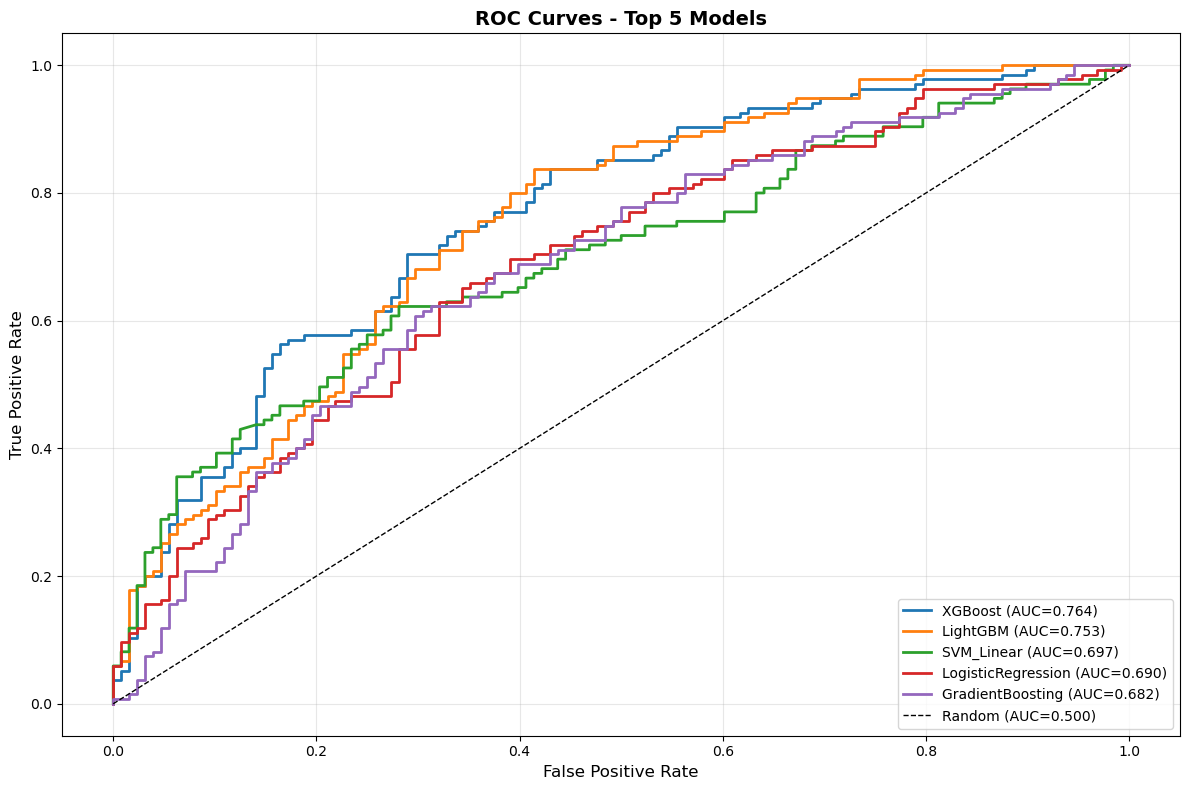

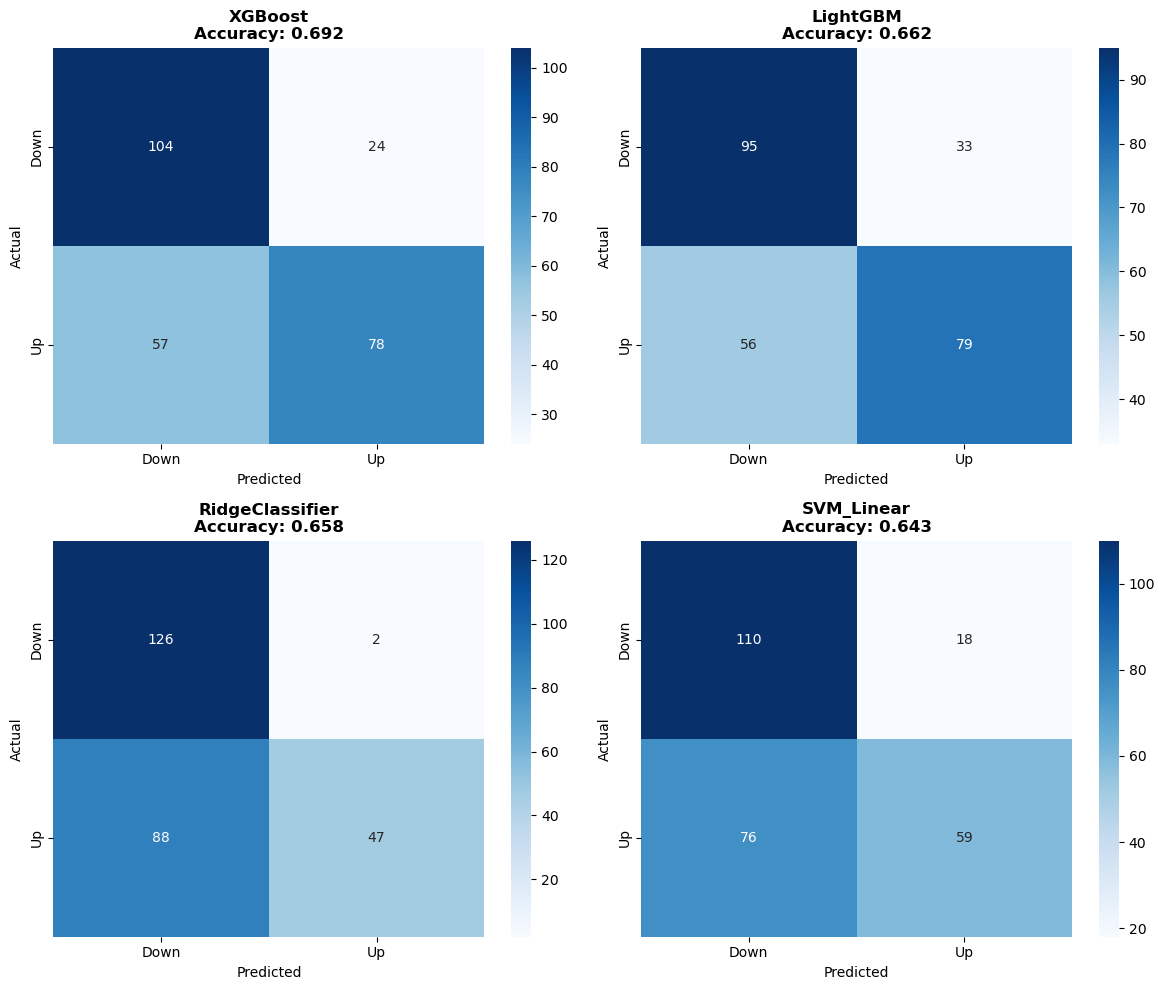

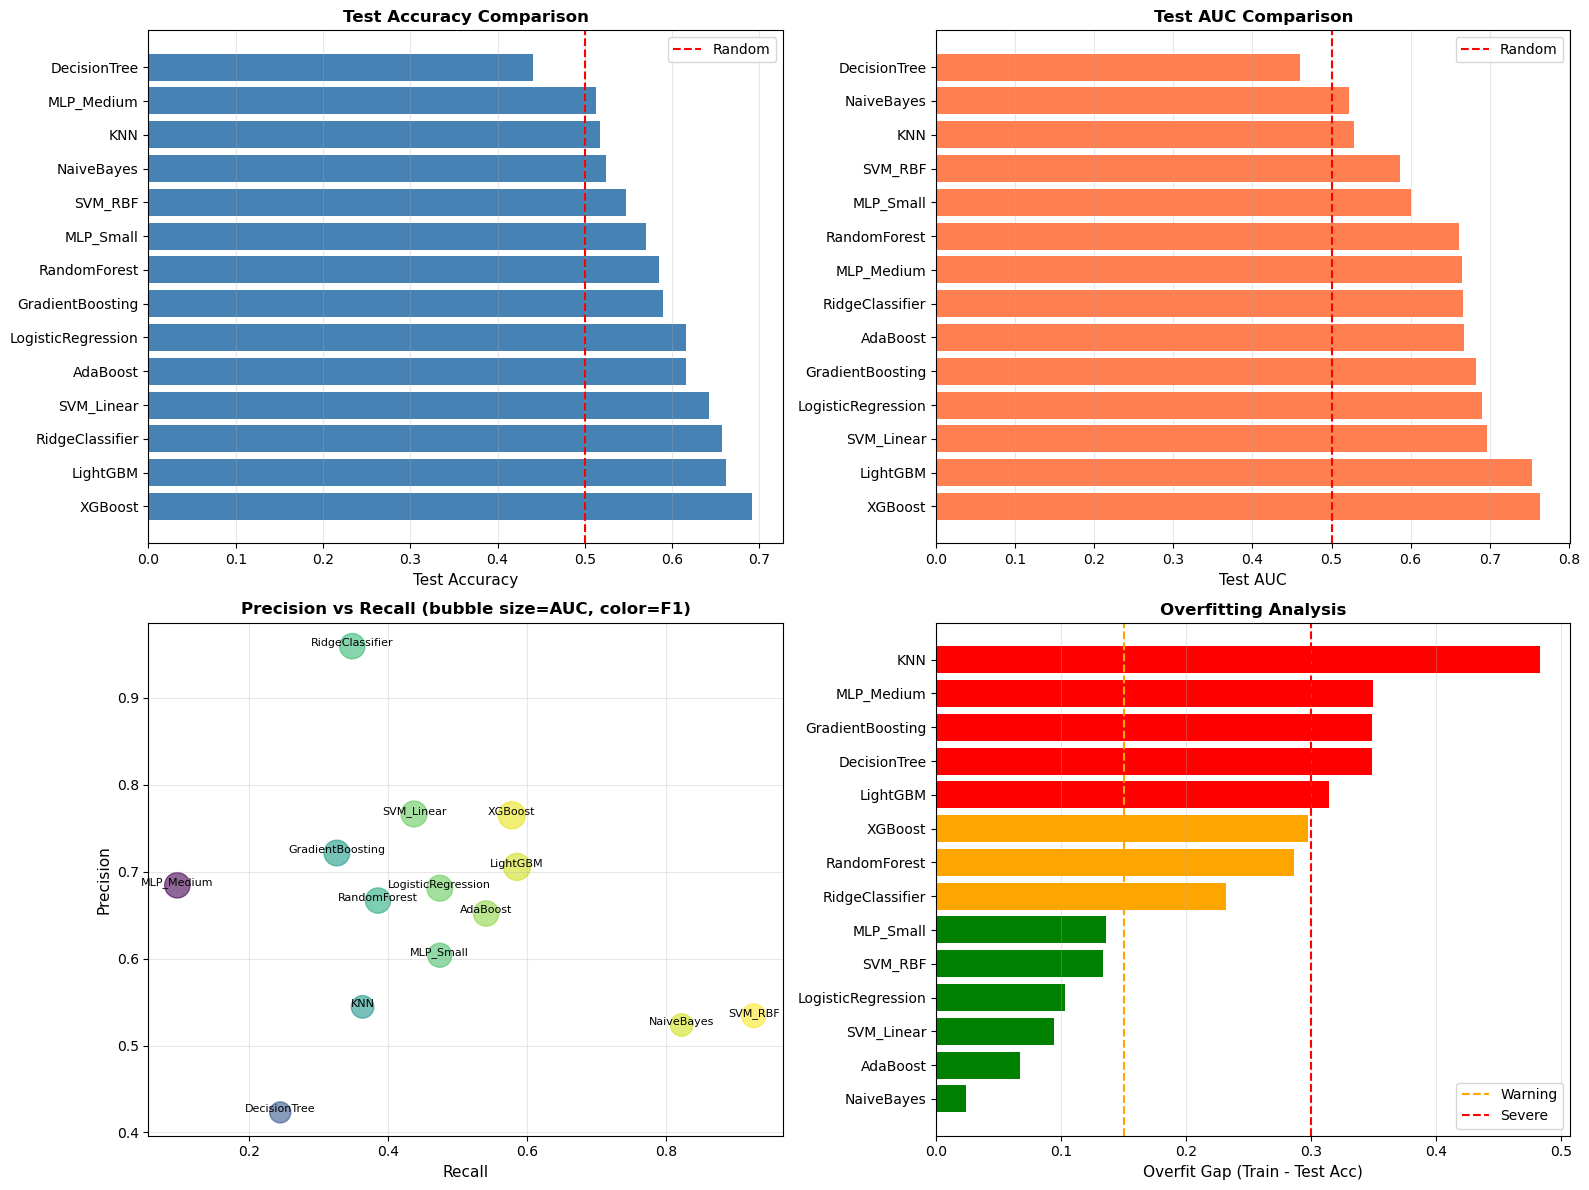

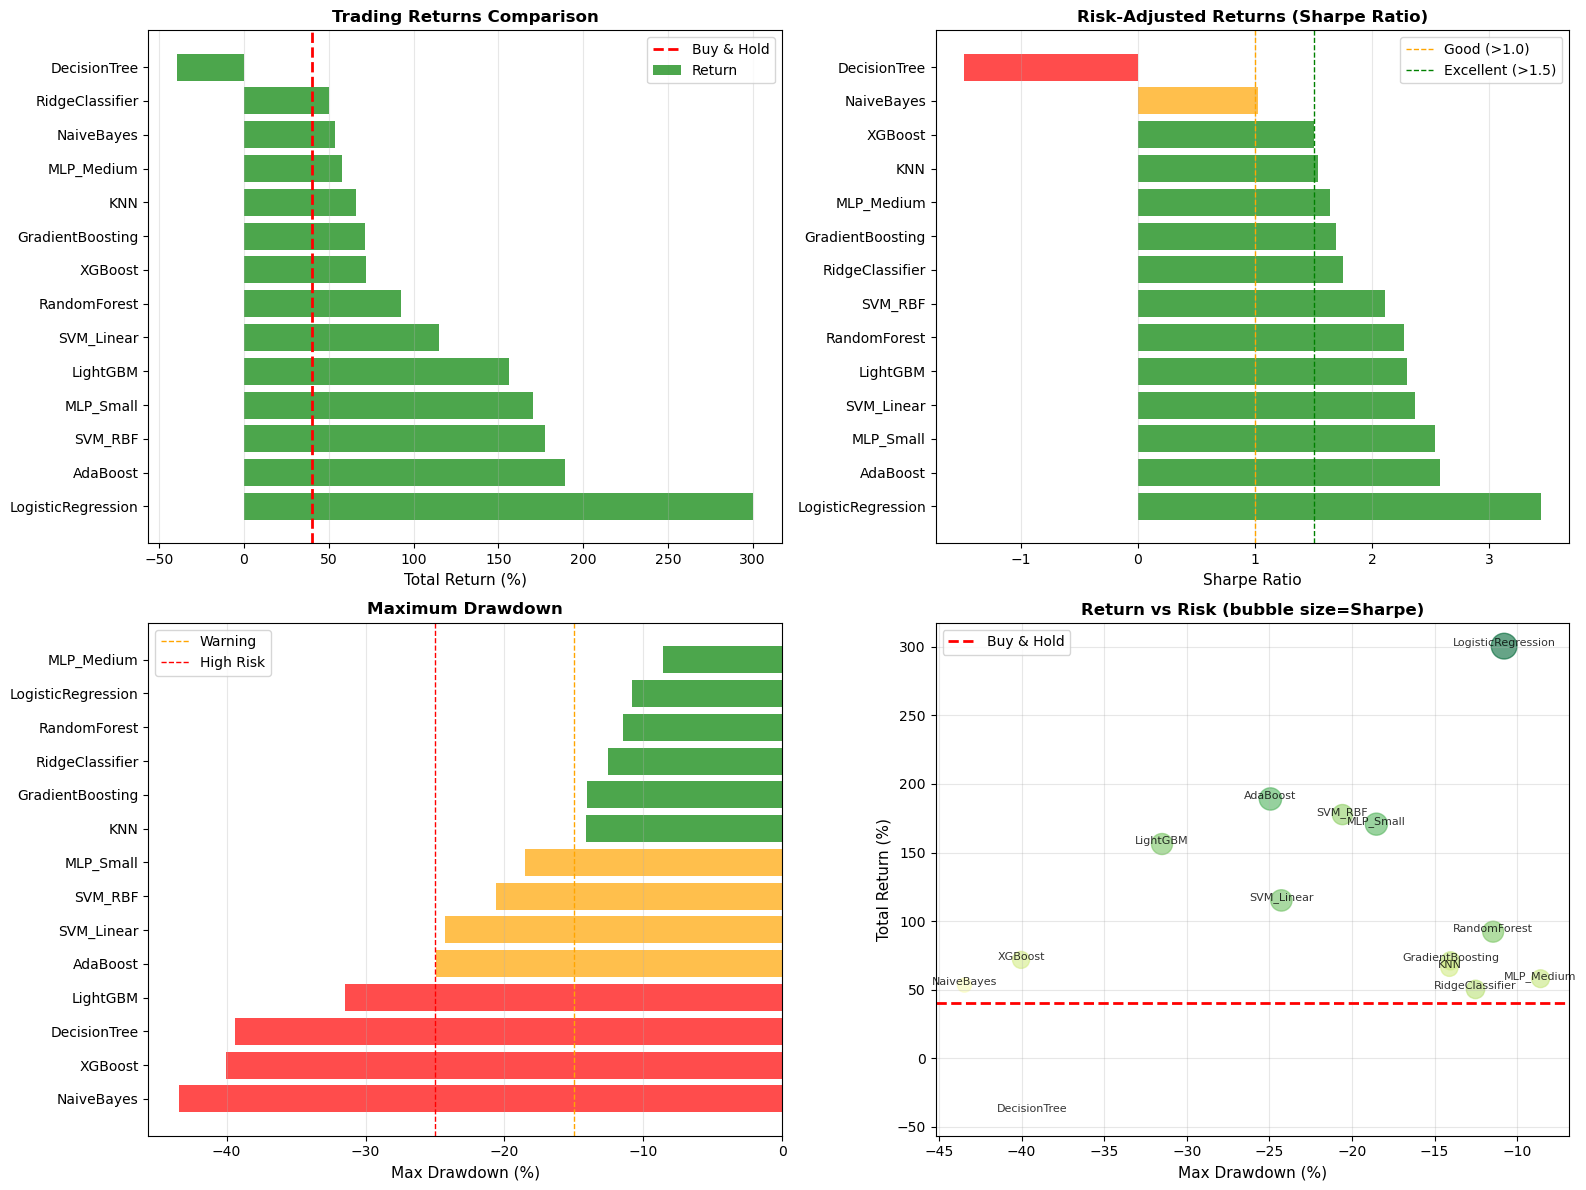

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')


def prepare_feature_target(df, task='classification'):
    exclude_cols = ['date', 'next_log_return', 'next_direction', 
                   'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Open']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df['next_direction'].copy() if task == 'classification' else df['next_log_return'].copy()
    dates = df['date'].copy()
    prices = df['ETH_Close'].copy()
    
    return X, y, dates, prices, feature_cols


def feature_selection_before_scaling(X_train, y_train, X_val, X_test, n_features=100):
    print(f"\n[Feature Selection] {X_train.shape[1]} → {n_features}")
    
    selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    selected_features = X_train.columns[selector.get_support()].tolist()
    print(f"  Selected: {len(selected_features)} features")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features


def scale_features(X_train, X_val, X_test):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


def train_all_models(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    논문 스타일: 모든 주요 모델 학습 및 평가
    """
    print("\n" + "="*120)
    print("Comprehensive Model Comparison (논문 스타일)")
    print("="*120)
    
    models_config = {
        # === Tree-based Models (GPU) ===
        'XGBoost': xgb.XGBClassifier(
            n_estimators=300, max_depth=5, learning_rate=0.03,
            subsample=0.75, colsample_bytree=0.75,
            reg_alpha=0.5, reg_lambda=2.0,
            tree_method='gpu_hist', random_state=42,
            early_stopping_rounds=50
        ),
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=300, max_depth=5, learning_rate=0.03,
            num_leaves=31, subsample=0.75, colsample_bytree=0.75,
            reg_alpha=0.5, reg_lambda=2.0,
            device='gpu', random_state=42, verbose=-1
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=20,
            min_samples_leaf=10, random_state=42, n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.03,
            subsample=0.75, random_state=42
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100, learning_rate=0.5, random_state=42
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=8, min_samples_split=20, min_samples_leaf=10,
            random_state=42
        ),
        
        # === Linear Models ===
        'LogisticRegression': LogisticRegression(
            C=0.1, penalty='l2', max_iter=2000, random_state=42, n_jobs=-1
        ),
        'RidgeClassifier': RidgeClassifier(
            alpha=1.0, random_state=42
        ),
        
        # === Support Vector Machines ===
        'SVM_RBF': SVC(
            kernel='rbf', C=1.0, gamma='scale', 
            probability=True, random_state=42
        ),
        'SVM_Linear': SVC(
            kernel='linear', C=0.1,
            probability=True, random_state=42
        ),
        
        # === Neural Networks ===
        'MLP_Small': MLPClassifier(
            hidden_layer_sizes=(64, 32), activation='relu',
            solver='adam', alpha=0.01, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        'MLP_Medium': MLPClassifier(
            hidden_layer_sizes=(128, 64, 32), activation='relu',
            solver='adam', alpha=0.001, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        
        # === Other Models ===
        'KNN': KNeighborsClassifier(
            n_neighbors=15, weights='distance', n_jobs=-1
        ),
        'NaiveBayes': GaussianNB()
    }
    
    results = []
    models_trained = {}
    predictions = {}
    probabilities = {}
    
    print(f"\n{'Model':<25} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12} {'Test AUC':<12} Status")
    print("-" * 120)
    
    for name, model in models_config.items():
        try:
            # 학습
            if name in ['XGBoost', 'LightGBM']:
                if name == 'XGBoost':
                    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                else:
                    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                             callbacks=[lgb.early_stopping(50, verbose=False)])
            else:
                model.fit(X_train, y_train)
            
            # 예측
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            # 확률 예측
            if hasattr(model, 'predict_proba'):
                train_proba = model.predict_proba(X_train)[:, 1]
                val_proba = model.predict_proba(X_val)[:, 1]
                test_proba = model.predict_proba(X_test)[:, 1]
            else:
                train_proba = train_pred
                val_proba = val_pred
                test_proba = test_pred
            
            # 메트릭 계산
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            test_precision = precision_score(y_test, test_pred, zero_division=0)
            test_recall = recall_score(y_test, test_pred, zero_division=0)
            test_f1 = f1_score(y_test, test_pred, zero_division=0)
            
            try:
                train_auc = roc_auc_score(y_train, train_proba)
                val_auc = roc_auc_score(y_val, val_proba)
                test_auc = roc_auc_score(y_test, test_proba)
            except:
                train_auc = val_auc = test_auc = 0.5
            
            # 결과 저장
            results.append({
                'Model': name,
                'Train_Acc': train_acc,
                'Val_Acc': val_acc,
                'Test_Acc': test_acc,
                'Train_AUC': train_auc,
                'Val_AUC': val_auc,
                'Test_AUC': test_auc,
                'Test_Precision': test_precision,
                'Test_Recall': test_recall,
                'Test_F1': test_f1,
                'Overfit_Gap': train_acc - test_acc
            })
            
            models_trained[name] = model
            predictions[name] = test_pred
            probabilities[name] = test_proba
            
            status = "✓"
            print(f"{name:<25} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f} {test_auc:<12.4f} {status}")
            
        except Exception as e:
            print(f"{name:<25} {'N/A':<12} {'N/A':<12} {'N/A':<12} {'N/A':<12} ✗ Error: {str(e)[:30]}")
    
    return pd.DataFrame(results), models_trained, predictions, probabilities


def create_comprehensive_report(results_df):
    """상세 성능 비교표"""
    print("\n" + "="*120)
    print("Detailed Performance Report")
    print("="*120)
    
    # 정렬: Test AUC 기준
    results_sorted = results_df.sort_values('Test_AUC', ascending=False).reset_index(drop=True)
    
    print(f"\n{'Rank':<6} {'Model':<25} {'Test Acc':<12} {'Test Prec':<12} {'Test Recall':<12} {'Test F1':<12} {'Test AUC':<12} {'Overfit':<12}")
    print("-" * 120)
    
    for idx, row in results_sorted.iterrows():
        print(f"{idx+1:<6} {row['Model']:<25} {row['Test_Acc']:<12.4f} {row['Test_Precision']:<12.4f} "
              f"{row['Test_Recall']:<12.4f} {row['Test_F1']:<12.4f} {row['Test_AUC']:<12.4f} {row['Overfit_Gap']:<12.4f}")
    
    # 통계 요약
    print("\n" + "="*120)
    print("Statistical Summary")
    print("="*120)
    print(f"Best Test Accuracy:  {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_Acc']:.4f})")
    print(f"Best Test AUC:       {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_AUC']:.4f})")
    print(f"Best Test F1:        {results_sorted.nlargest(1, 'Test_F1').iloc[0]['Model']} ({results_sorted['Test_F1'].max():.4f})")
    print(f"\nMean Test Accuracy:  {results_df['Test_Acc'].mean():.4f} ± {results_df['Test_Acc'].std():.4f}")
    print(f"Mean Test AUC:       {results_df['Test_AUC'].mean():.4f} ± {results_df['Test_AUC'].std():.4f}")
    print(f"Mean Overfit Gap:    {results_df['Overfit_Gap'].mean():.4f} ± {results_df['Overfit_Gap'].std():.4f}")
    
    return results_sorted


def plot_roc_curves(models, probabilities, y_test, top_n=5):
    """ROC Curve 시각화 (Top N 모델)"""
    plt.figure(figsize=(12, 8))
    
    # AUC 계산 및 정렬
    auc_scores = {}
    for name, proba in probabilities.items():
        try:
            auc = roc_auc_score(y_test, proba)
            auc_scores[name] = auc
        except:
            pass
    
    # Top N 모델 선택
    top_models = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    for name, auc in top_models:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
    
    # 랜덤 기준선
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Top 5 Models', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    print("\n✓ ROC Curve 저장: roc_curves.png")


def plot_confusion_matrices(models, predictions, y_test, top_n=4):
    """Confusion Matrix 시각화 (Top N 모델)"""
    # Top N 모델 선택 (정확도 기준)
    accuracies = {name: accuracy_score(y_test, pred) for name, pred in predictions.items()}
    top_models = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, (name, acc) in enumerate(top_models):
        cm = confusion_matrix(y_test, predictions[name])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        axes[idx].set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    print("✓ Confusion Matrix 저장: confusion_matrices.png")


def plot_performance_comparison(results_df):
    """성능 비교 차트"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Test Accuracy 비교
    results_sorted = results_df.sort_values('Test_Acc', ascending=False)
    axes[0, 0].barh(results_sorted['Model'], results_sorted['Test_Acc'], color='steelblue')
    axes[0, 0].set_xlabel('Test Accuracy', fontsize=11)
    axes[0, 0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Random')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Test AUC 비교
    results_sorted = results_df.sort_values('Test_AUC', ascending=False)
    axes[0, 1].barh(results_sorted['Model'], results_sorted['Test_AUC'], color='coral')
    axes[0, 1].set_xlabel('Test AUC', fontsize=11)
    axes[0, 1].set_title('Test AUC Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(0.5, color='red', linestyle='--', label='Random')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Precision vs Recall
    axes[1, 0].scatter(results_df['Test_Recall'], results_df['Test_Precision'], 
                      s=results_df['Test_AUC']*500, alpha=0.6, c=results_df['Test_F1'], cmap='viridis')
    for idx, row in results_df.iterrows():
        axes[1, 0].annotate(row['Model'], (row['Test_Recall'], row['Test_Precision']), 
                           fontsize=8, ha='center')
    axes[1, 0].set_xlabel('Recall', fontsize=11)
    axes[1, 0].set_ylabel('Precision', fontsize=11)
    axes[1, 0].set_title('Precision vs Recall (bubble size=AUC, color=F1)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Overfitting Analysis
    results_sorted = results_df.sort_values('Overfit_Gap', ascending=True)
    colors = ['green' if x < 0.15 else 'orange' if x < 0.3 else 'red' for x in results_sorted['Overfit_Gap']]
    axes[1, 1].barh(results_sorted['Model'], results_sorted['Overfit_Gap'], color=colors)
    axes[1, 1].set_xlabel('Overfit Gap (Train - Test Acc)', fontsize=11)
    axes[1, 1].set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
    axes[1, 1].axvline(0.15, color='orange', linestyle='--', label='Warning')
    axes[1, 1].axvline(0.30, color='red', linestyle='--', label='Severe')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ 성능 비교 차트 저장: performance_comparison.png")


def calculate_trading_performance_fixed(predictions, probabilities, dates, prices, y_true,
                                        initial_capital=10000, transaction_cost=0.0015):
    """
    수정된 백테스트 (Look-Ahead Bias 제거 및 일일 평가 적용)
    - 기존 함수의 입출력 구조를 완벽히 유지합니다.
    """
    df_backtest = pd.DataFrame({
        'date': dates.values,
        'price': prices.values,
        'prediction': predictions,
        'probability': probabilities,
        'actual_direction': y_true.values
    })
    
    capital = initial_capital
    position = 0
    eth_holdings = 0
    # ✅ 포트폴리오 가치 리스트에 초기 자본을 첫 값으로 설정 (정확한 수익률 계산 위함)
    portfolio_values = [initial_capital]
    trades = []
    
    # ✅ 루프 범위를 `len - 1`로 수정하여 마지막 날의 거래까지 반영
    for idx in range(len(df_backtest) - 1):
        # t일의 예측 정보
        current_row = df_backtest.iloc[idx]
        signal = current_row['prediction']
        confidence = current_row['probability']
        
        # t+1일의 거래 가격
        trade_price = df_backtest.iloc[idx + 1]['price']
        
        # ✅ next_price (t+2 가격) 변수 제거. 미래 정보를 사용하지 않습니다.

        # 거래 로직 (기존과 동일)
        if signal == 1 and position == 0 and confidence > 0.55:
            eth_to_buy = (capital * 0.95) / trade_price
            cost = eth_to_buy * trade_price * (1 + transaction_cost)
            if cost <= capital:
                eth_holdings = eth_to_buy
                capital -= cost
                position = 1
                trades.append({'action': 'BUY', 'price': trade_price})

        elif (signal == 0 or confidence < 0.45) and position == 1:
            revenue = eth_holdings * trade_price * (1 - transaction_cost)
            capital += revenue
            eth_holdings = 0
            position = 0
            trades.append({'action': 'SELL', 'price': trade_price})
            
        # ✅ 포트폴리오 가치를 t+1일의 가격(trade_price)으로 평가
        eod_portfolio_value = capital + (eth_holdings * trade_price)
        portfolio_values.append(eod_portfolio_value)

    # --- 최종 성과 계산 (기존 구조 유지) ---
    final_value = portfolio_values[-1]
    
    # 만약 마지막 날에 포지션을 들고 있었다면, 최종 가치는 이미 계산되었으므로
    # capital을 직접 수정할 필요가 없습니다. final_value를 사용합니다.
    
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_hold_return = (df_backtest.iloc[-1]['price'] - df_backtest.iloc[0]['price']) / df_backtest.iloc[0]['price'] * 100
    
    portfolio_values = np.array(portfolio_values)
    if len(portfolio_values) > 1:
        # ✅ 일일 수익률을 (오늘 가치 / 어제 가치) - 1 로 계산하여 더 정확해짐
        returns = (portfolio_values[1:] / portfolio_values[:-1]) - 1
        returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
        
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else 0
        
        cummax = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - cummax) / cummax
        max_drawdown = np.min(drawdown) * 100 if len(drawdown) > 0 else 0
    else:
        sharpe_ratio = 0
        max_drawdown = 0
        
    n_trades = len(trades)
    n_buys = len([t for t in trades if t['action'] == 'BUY'])
    
    # ✅ 기존과 동일한 반환값 구조
    return {
        'final_value': final_value,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'n_trades': n_trades,
        'n_buys': n_buys
    }


def backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test):
    """모든 모델에 대해 백테스팅 수행"""
    print("\n" + "="*120)
    print("Trading Backtest Results (All Models)")
    print("="*120)
    
    backtest_results = []
    
    # Buy & Hold 기준
    buy_hold_return = (test_prices.iloc[-1] - test_prices.iloc[0]) / test_prices.iloc[0] * 100
    
    print(f"\n{'Model':<25} {'Final Value':<15} {'Return %':<12} {'vs B&H':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<10}")
    print("-" * 120)
    
    for name in models.keys():
        try:
            results = calculate_trading_performance_fixed(
                predictions[name], 
                probabilities[name],
                test_dates, 
                test_prices, 
                y_test,
                initial_capital=10000,
                transaction_cost=0.0015
            )
            
            outperformance = results['total_return'] - buy_hold_return
            
            backtest_results.append({
                'Model': name,
                'Final_Value': results['final_value'],
                'Total_Return': results['total_return'],
                'Buy_Hold_Return': buy_hold_return,
                'Outperformance': outperformance,
                'Sharpe_Ratio': results['sharpe_ratio'],
                'Max_Drawdown': results['max_drawdown'],
                'N_Trades': results['n_trades'],
                'N_Buys': results['n_buys']
            })
            
            print(f"{name:<25} ${results['final_value']:<14,.2f} {results['total_return']:<11.2f}% "
                  f"{outperformance:<11.2f}% {results['sharpe_ratio']:<9.3f} "
                  f"{results['max_drawdown']:<11.2f}% {results['n_trades']:<10}")
            
        except Exception as e:
            print(f"{name:<25} Error: {str(e)[:50]}")
    
    print("-" * 120)
    print(f"{'Buy & Hold Baseline':<25} ${10000 * (1 + buy_hold_return/100):<14,.2f} {buy_hold_return:<11.2f}% "
          f"{'0.00':<11}% {'N/A':<9} {'N/A':<11} {'0':<10}")
    
    return pd.DataFrame(backtest_results)


def create_backtest_report(backtest_df):
    """백테스팅 결과 상세 분석"""
    print("\n" + "="*120)
    print("Backtest Performance Ranking")
    print("="*120)
    
    # Return 기준 정렬
    backtest_sorted = backtest_df.sort_values('Total_Return', ascending=False).reset_index(drop=True)
    
    print(f"\n{'Rank':<6} {'Model':<25} {'Return %':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<10} {'Risk Score':<12}")
    print("-" * 120)
    
    for idx, row in backtest_sorted.iterrows():
        # Risk Score: Sharpe / |MaxDD| (높을수록 좋음)
        risk_score = abs(row['Sharpe_Ratio'] / row['Max_Drawdown']) * 100 if row['Max_Drawdown'] != 0 else 0
        
        print(f"{idx+1:<6} {row['Model']:<25} {row['Total_Return']:<11.2f}% {row['Sharpe_Ratio']:<9.3f} "
              f"{row['Max_Drawdown']:<11.2f}% {row['N_Trades']:<10} {risk_score:<11.3f}")
    
    # 통계 요약
    print("\n" + "="*120)
    print("Backtest Statistical Summary")
    print("="*120)
    print(f"Best Return:         {backtest_sorted.iloc[0]['Model']} ({backtest_sorted.iloc[0]['Total_Return']:.2f}%)")
    print(f"Best Sharpe Ratio:   {backtest_df.nlargest(1, 'Sharpe_Ratio').iloc[0]['Model']} ({backtest_df['Sharpe_Ratio'].max():.3f})")
    print(f"Lowest Drawdown:     {backtest_df.nsmallest(1, 'Max_Drawdown').iloc[0]['Model']} ({backtest_df['Max_Drawdown'].min():.2f}%)")
    print(f"\nMean Return:         {backtest_df['Total_Return'].mean():.2f}% ± {backtest_df['Total_Return'].std():.2f}%")
    print(f"Mean Sharpe:         {backtest_df['Sharpe_Ratio'].mean():.3f} ± {backtest_df['Sharpe_Ratio'].std():.3f}")
    print(f"Mean Max Drawdown:   {backtest_df['Max_Drawdown'].mean():.2f}% ± {backtest_df['Max_Drawdown'].std():.2f}%")
    
    # 위험 등급 분류
    print("\n" + "="*120)
    print("Risk Classification")
    print("="*120)
    
    conservative = backtest_df[(backtest_df['Max_Drawdown'] > -20) & (backtest_df['Sharpe_Ratio'] > 1.0)]
    moderate = backtest_df[(backtest_df['Max_Drawdown'] > -30) & (backtest_df['Sharpe_Ratio'] > 0.5)]
    aggressive = backtest_df[~backtest_df.index.isin(conservative.index.union(moderate.index))]
    
    print(f"Conservative (Low Risk):  {len(conservative)} models - {conservative['Model'].tolist() if len(conservative) > 0 else 'None'}")
    print(f"Moderate (Medium Risk):   {len(moderate)} models - {moderate['Model'].tolist() if len(moderate) > 0 else 'None'}")
    print(f"Aggressive (High Risk):   {len(aggressive)} models - {aggressive['Model'].tolist() if len(aggressive) > 0 else 'None'}")
    
    return backtest_sorted


def plot_backtest_comparison(backtest_df):
    """백테스트 결과 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Return vs Sharpe
    backtest_sorted = backtest_df.sort_values('Total_Return', ascending=False)
    axes[0, 0].barh(backtest_sorted['Model'], backtest_sorted['Total_Return'], color='green', alpha=0.7, label='Return')
    axes[0, 0].axvline(backtest_df['Buy_Hold_Return'].iloc[0], color='red', linestyle='--', linewidth=2, label='Buy & Hold')
    axes[0, 0].set_xlabel('Total Return (%)', fontsize=11)
    axes[0, 0].set_title('Trading Returns Comparison', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Sharpe Ratio
    backtest_sorted = backtest_df.sort_values('Sharpe_Ratio', ascending=False)
    colors = ['green' if x > 1.5 else 'orange' if x > 0.8 else 'red' for x in backtest_sorted['Sharpe_Ratio']]
    axes[0, 1].barh(backtest_sorted['Model'], backtest_sorted['Sharpe_Ratio'], color=colors, alpha=0.7)
    axes[0, 1].axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good (>1.0)')
    axes[0, 1].axvline(1.5, color='green', linestyle='--', linewidth=1, label='Excellent (>1.5)')
    axes[0, 1].set_xlabel('Sharpe Ratio', fontsize=11)
    axes[0, 1].set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Max Drawdown
    backtest_sorted = backtest_df.sort_values('Max_Drawdown', ascending=True)
    colors = ['green' if x > -15 else 'orange' if x > -25 else 'red' for x in backtest_sorted['Max_Drawdown']]
    axes[1, 0].barh(backtest_sorted['Model'], backtest_sorted['Max_Drawdown'], color=colors, alpha=0.7)
    axes[1, 0].axvline(-15, color='orange', linestyle='--', linewidth=1, label='Warning')
    axes[1, 0].axvline(-25, color='red', linestyle='--', linewidth=1, label='High Risk')
    axes[1, 0].set_xlabel('Max Drawdown (%)', fontsize=11)
    axes[1, 0].set_title('Maximum Drawdown', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 4. Return vs Risk (Scatter)
    axes[1, 1].scatter(backtest_df['Max_Drawdown'], backtest_df['Total_Return'], 
                      s=backtest_df['Sharpe_Ratio']*100, alpha=0.6, c=backtest_df['Sharpe_Ratio'], cmap='RdYlGn')
    for idx, row in backtest_df.iterrows():
        axes[1, 1].annotate(row['Model'], (row['Max_Drawdown'], row['Total_Return']), 
                           fontsize=8, ha='center', alpha=0.8)
    axes[1, 1].axhline(backtest_df['Buy_Hold_Return'].iloc[0], color='red', linestyle='--', linewidth=2, label='Buy & Hold')
    axes[1, 1].set_xlabel('Max Drawdown (%)', fontsize=11)
    axes[1, 1].set_ylabel('Total Return (%)', fontsize=11)
    axes[1, 1].set_title('Return vs Risk (bubble size=Sharpe)', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('backtest_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ 백테스트 비교 차트 저장: backtest_comparison.png")


# ============================================================================
# 완전한 메인 실행 (백테스팅 포함)
# ============================================================================
print("="*120)
print("Comprehensive ML Model Comparison for Ethereum Price Prediction")
print("="*120)

# 1. 데이터 준비
X_train, y_train, train_dates, train_prices, _ = prepare_feature_target(train_df)
X_val, y_val, val_dates, val_prices, _ = prepare_feature_target(val_df)
X_test, y_test, test_dates, test_prices, _ = prepare_feature_target(test_df)

print(f"\nDataset: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# 2. 전처리
X_train_selected, X_val_selected, X_test_selected, _ = \
    feature_selection_before_scaling(X_train, y_train, X_val, X_test, n_features=100)
X_train_scaled, X_val_scaled, X_test_scaled, _ = \
    scale_features(X_train_selected, X_val_selected, X_test_selected)

# 3. 모든 모델 학습 및 평가
results_df, models, predictions, probabilities = \
    train_all_models(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# 4. 상세 리포트
results_sorted = create_comprehensive_report(results_df)

# 5. 백테스팅
backtest_df = backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test)
backtest_sorted = create_backtest_report(backtest_df)

# 6. 시각화
plot_roc_curves(models, probabilities, y_test, top_n=5)
plot_confusion_matrices(models, predictions, y_test, top_n=4)
plot_performance_comparison(results_df)
plot_backtest_comparison(backtest_df)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, VotingClassifier, StackingClassifier, 
    BaggingClassifier, ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')


def prepare_feature_target(df, task='classification'):
    exclude_cols = ['date', 'next_log_return', 'next_direction', 
                   'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Open']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df['next_direction'].copy() if task == 'classification' else df['next_log_return'].copy()
    dates = df['date'].copy()
    prices = df['ETH_Close'].copy()
    
    return X, y, dates, prices, feature_cols


def check_data_leakage(X_train, X_val, X_test, train_dates, val_dates, test_dates):
    print("\n" + "="*100)
    print("DATA LEAKAGE VERIFICATION")
    print("="*100)
    
    issues = []
    
    train_idx = set(X_train.index)
    val_idx = set(X_val.index)
    test_idx = set(X_test.index)
    
    if len(train_idx & val_idx) > 0:
        issues.append("CRITICAL: Train and validation index overlap")
    if len(train_idx & test_idx) > 0:
        issues.append("CRITICAL: Train and test index overlap")
    if len(val_idx & test_idx) > 0:
        issues.append("CRITICAL: Validation and test index overlap")
    
    if train_dates.max() >= val_dates.min():
        issues.append("CRITICAL: Train dates overlap with validation dates")
    if val_dates.max() >= test_dates.min():
        issues.append("CRITICAL: Validation dates overlap with test dates")
    
    if X_train.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Train has {X_train.isnull().sum().sum()} NaN values")
    if X_val.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Validation has {X_val.isnull().sum().sum()} NaN values")
    if X_test.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Test has {X_test.isnull().sum().sum()} NaN values")
    
    if np.isinf(X_train).sum().sum() > 0:
        issues.append(f"WARNING: Train has {np.isinf(X_train).sum().sum()} inf values")
    if np.isinf(X_val).sum().sum() > 0:
        issues.append(f"WARNING: Validation has {np.isinf(X_val).sum().sum()} inf values")
    if np.isinf(X_test).sum().sum() > 0:
        issues.append(f"WARNING: Test has {np.isinf(X_test).sum().sum()} inf values")
    
    print(f"\nTrain: {len(X_train)} samples, {train_dates.min()} to {train_dates.max()}")
    print(f"Val:   {len(X_val)} samples, {val_dates.min()} to {val_dates.max()}")
    print(f"Test:  {len(X_test)} samples, {test_dates.min()} to {test_dates.max()}")
    
    if len(issues) == 0:
        print("\n✓ No data leakage detected")
        return True
    else:
        print("\n✗ Data leakage issues detected:")
        for issue in issues:
            print(f"  {issue}")
        return False


def feature_selection_before_scaling(X_train, y_train, X_val, X_test, n_features=100):
    print(f"\n[FEATURE SELECTION] {X_train.shape[1]} -> {n_features}")
    
    selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    selected_features = X_train.columns[selector.get_support()].tolist()
    print(f"  Selected: {len(selected_features)} features")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features


def scale_features(X_train, X_val, X_test):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


def get_all_models():
    base_models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=20,
            min_samples_leaf=10, random_state=42, n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.03,
            subsample=0.75, random_state=42
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200, max_depth=10, min_samples_split=20,
            min_samples_leaf=10, random_state=42, n_jobs=-1
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100, learning_rate=0.5, random_state=42
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=8, min_samples_split=20, min_samples_leaf=10,
            random_state=42
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1, penalty='l2', max_iter=2000, random_state=42, n_jobs=-1
        ),
        'RidgeClassifier': RidgeClassifier(
            alpha=1.0, random_state=42
        ),
        'SVM_RBF': SVC(
            kernel='rbf', C=1.0, gamma='scale', 
            probability=True, random_state=42
        ),
        'SVM_Linear': SVC(
            kernel='linear', C=0.1,
            probability=True, random_state=42
        ),
        'MLP_Small': MLPClassifier(
            hidden_layer_sizes=(64, 32), activation='relu',
            solver='adam', alpha=0.01, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        'MLP_Medium': MLPClassifier(
            hidden_layer_sizes=(128, 64, 32), activation='relu',
            solver='adam', alpha=0.001, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=15, weights='distance', n_jobs=-1
        ),
        'NaiveBayes': GaussianNB(),
        'Bagging_RF': BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=8, random_state=42),
            n_estimators=50, random_state=42, n_jobs=-1
        ),
        
        'XGBoost_GPU': XGBClassifier(
            n_estimators=300,            # 트리 개수
            learning_rate=0.05,          # 학습률 (낮을수록 과적합 방지)
            max_depth=4,                 # 트리의 최대 깊이 (낮을수록 과적합 방지)
            subsample=0.8,               # 각 트리마다 사용할 훈련 데이터 샘플 비율
            colsample_bytree=0.8,        # 각 트리마다 사용할 특징 비율
            gamma=0.1,                   # 리프 노드를 추가적으로 나눌지 결정하는 최소 손실 감소 값
            reg_alpha=0.01,              # L1 정규화 (가중치 절대값에 대한 패널티)
            reg_lambda=1,                # L2 정규화 (가중치 제곱에 대한 패널티)
            tree_method='gpu_hist',      # GPU 사용 설정
            random_state=42
        ),
        'LightGBM_GPU': LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=25,               # 리프 노드 수 (max_depth보다 중요할 수 있음)
            max_depth=5,                 # 명시적으로 깊이 제한
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.01,
            reg_lambda=1,
            device='gpu',                # GPU 사용 설정
            random_state=42,
            n_jobs=-1
        ),
    }
    
    voting_soft = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('lr', LogisticRegression(C=0.1, random_state=42, n_jobs=-1))
        ],
        voting='soft'
    )
    
    voting_hard = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('lr', LogisticRegression(C=0.1, random_state=42, n_jobs=-1))
        ],
        voting='hard'
    )
    
    stacking = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('et', ExtraTreesClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
        ],
        final_estimator=LogisticRegression(C=0.1, random_state=42),
        cv=5
    )
    
    base_models['Voting_Soft'] = voting_soft
    base_models['Voting_Hard'] = voting_hard
    base_models['Stacking'] = stacking
    
    return base_models


def train_all_models(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n" + "="*100)
    print("MODEL TRAINING AND EVALUATION")
    print("="*100)
    
    models_config = get_all_models()
    
    results = []
    models_trained = {}
    predictions = {}
    probabilities = {}
    
    print(f"\n{'Model':<25} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12} {'Test AUC':<12} Status")
    print("-" * 100)
    
    for name, model in models_config.items():
        try:
            model.fit(X_train, y_train)
            
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            if hasattr(model, 'predict_proba'):
                train_proba = model.predict_proba(X_train)[:, 1]
                val_proba = model.predict_proba(X_val)[:, 1]
                test_proba = model.predict_proba(X_test)[:, 1]
            else:
                train_proba = train_pred
                val_proba = val_pred
                test_proba = test_pred
            
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            test_precision = precision_score(y_test, test_pred, zero_division=0)
            test_recall = recall_score(y_test, test_pred, zero_division=0)
            test_f1 = f1_score(y_test, test_pred, zero_division=0)
            
            try:
                train_auc = roc_auc_score(y_train, train_proba)
                val_auc = roc_auc_score(y_val, val_proba)
                test_auc = roc_auc_score(y_test, test_proba)
            except:
                train_auc = val_auc = test_auc = 0.5
            
            results.append({
                'Model': name,
                'Train_Acc': train_acc,
                'Val_Acc': val_acc,
                'Test_Acc': test_acc,
                'Train_AUC': train_auc,
                'Val_AUC': val_auc,
                'Test_AUC': test_auc,
                'Test_Precision': test_precision,
                'Test_Recall': test_recall,
                'Test_F1': test_f1,
                'Overfit_Gap': train_acc - test_acc
            })
            
            models_trained[name] = model
            predictions[name] = test_pred
            probabilities[name] = test_proba
            
            status = "OK"
            print(f"{name:<25} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f} {test_auc:<12.4f} {status}")
            
        except Exception as e:
            print(f"{name:<25} {'ERROR':<12} {'ERROR':<12} {'ERROR':<12} {'ERROR':<12} {str(e)[:20]}")
    
    return pd.DataFrame(results), models_trained, predictions, probabilities


def walk_forward_validation(df, models_config, n_splits=5, n_features=100):
    print("\n" + "="*100)
    print("WALK-FORWARD VALIDATION")
    print("="*100)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    X, y, dates, prices, feature_cols = prepare_feature_target(df)
    all_results = []
    fold_num = 0
    
    for train_idx, test_idx in tscv.split(X):
        fold_num += 1
        print(f"\n--- Fold {fold_num}/{n_splits} ---")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_test_fold = y.iloc[test_idx]
        
        print(f"Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        
        selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train_fold.shape[1]))
        X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)
        X_test_selected = selector.transform(X_test_fold)
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        
        # 전달받은 models_config 사용
        for name, model in models_config.items():
            try:
                # 모델을 복사해서 사용 (원본 모델 보호)
                from sklearn.base import clone
                model_copy = clone(model)
                
                model_copy.fit(X_train_scaled, y_train_fold)
                test_pred = model_copy.predict(X_test_scaled)
                
                if hasattr(model_copy, 'predict_proba'):
                    test_proba = model_copy.predict_proba(X_test_scaled)[:, 1]
                else:
                    test_proba = test_pred
                
                test_acc = accuracy_score(y_test_fold, test_pred)
                test_precision = precision_score(y_test_fold, test_pred, zero_division=0)
                test_recall = recall_score(y_test_fold, test_pred, zero_division=0)
                test_f1 = f1_score(y_test_fold, test_pred, zero_division=0)
                
                try:
                    test_auc = roc_auc_score(y_test_fold, test_proba)
                except:
                    test_auc = 0.5
                
                all_results.append({
                    'Fold': fold_num,
                    'Model': name,
                    'Test_Acc': test_acc,
                    'Test_Precision': test_precision,
                    'Test_Recall': test_recall,
                    'Test_F1': test_f1,
                    'Test_AUC': test_auc
                })
                
            except Exception as e:
                print(f"  {name}: Error - {str(e)[:50]}")
    
    results_df = pd.DataFrame(all_results)
    
    print("\n" + "="*100)
    print("WALK-FORWARD VALIDATION SUMMARY")
    print("="*100)
    
    summary = results_df.groupby('Model').agg({
        'Test_Acc': ['mean', 'std'],
        'Test_Precision': ['mean', 'std'],
        'Test_Recall': ['mean', 'std'],
        'Test_F1': ['mean', 'std'],
        'Test_AUC': ['mean', 'std']
    }).round(4)
    
    print("\n", summary)
    
    return results_df, summary  


def calculate_trading_performance_corrected(predictions, probabilities, dates, prices, y_true,
                                           initial_capital=10000, transaction_cost=0.0015):
    df_backtest = pd.DataFrame({
        'date': dates.values,
        'price': prices.values,
        'prediction': predictions,
        'probability': probabilities,
        'actual_direction': y_true.values
    })
    
    capital = initial_capital
    position = 0
    eth_holdings = 0
    portfolio_values = [initial_capital]
    trades = []
    
    for idx in range(len(df_backtest) - 1):
        current_row = df_backtest.iloc[idx]
        signal = current_row['prediction']
        confidence = current_row['probability']
        
        trade_price = df_backtest.iloc[idx + 1]['price']
        
        if signal == 1 and position == 0 and confidence > 0.55:
            eth_to_buy = (capital * 0.95) / trade_price
            cost = eth_to_buy * trade_price * (1 + transaction_cost)
            if cost <= capital:
                eth_holdings = eth_to_buy
                capital -= cost
                position = 1
                trades.append({'action': 'BUY', 'price': trade_price, 'date': df_backtest.iloc[idx + 1]['date']})

        elif (signal == 0 or confidence < 0.45) and position == 1:
            revenue = eth_holdings * trade_price * (1 - transaction_cost)
            capital += revenue
            eth_holdings = 0
            position = 0
            trades.append({'action': 'SELL', 'price': trade_price, 'date': df_backtest.iloc[idx + 1]['date']})
            
        eod_portfolio_value = capital + (eth_holdings * trade_price)
        portfolio_values.append(eod_portfolio_value)

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_hold_return = (df_backtest.iloc[-1]['price'] - df_backtest.iloc[0]['price']) / df_backtest.iloc[0]['price'] * 100
    
    portfolio_values = np.array(portfolio_values)
    if len(portfolio_values) > 1:
        returns = (portfolio_values[1:] / portfolio_values[:-1]) - 1
        returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
        
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else 0
        
        cummax = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - cummax) / cummax
        max_drawdown = np.min(drawdown) * 100 if len(drawdown) > 0 else 0
    else:
        sharpe_ratio = 0
        max_drawdown = 0
        
    n_trades = len(trades)
    n_buys = len([t for t in trades if t['action'] == 'BUY'])
    
    return {
        'final_value': final_value,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'n_trades': n_trades,
        'n_buys': n_buys
    }


def backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test):
    print("\n" + "="*100)
    print("BACKTESTING RESULTS")
    print("="*100)
    
    backtest_results = []
    
    buy_hold_return = (test_prices.iloc[-1] - test_prices.iloc[0]) / test_prices.iloc[0] * 100
    
    print(f"\n{'Model':<25} {'Final Value':<15} {'Return %':<12} {'vs B&H':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<10}")
    print("-" * 100)
    
    for name in models.keys():
        try:
            results = calculate_trading_performance_corrected(
                predictions[name], 
                probabilities[name],
                test_dates, 
                test_prices, 
                y_test,
                initial_capital=10000,
                transaction_cost=0.0015
            )
            
            outperformance = results['total_return'] - buy_hold_return
            
            backtest_results.append({
                'Model': name,
                'Final_Value': results['final_value'],
                'Total_Return': results['total_return'],
                'Buy_Hold_Return': buy_hold_return,
                'Outperformance': outperformance,
                'Sharpe_Ratio': results['sharpe_ratio'],
                'Max_Drawdown': results['max_drawdown'],
                'N_Trades': results['n_trades'],
                'N_Buys': results['n_buys']
            })
            
            print(f"{name:<25} ${results['final_value']:<14,.2f} {results['total_return']:<11.2f}% "
                  f"{outperformance:<11.2f}% {results['sharpe_ratio']:<9.3f} "
                  f"{results['max_drawdown']:<11.2f}% {results['n_trades']:<10}")
            
        except Exception as e:
            print(f"{name:<25} Error: {str(e)[:50]}")
    
    print("-" * 100)
    print(f"{'Buy & Hold Baseline':<25} ${10000 * (1 + buy_hold_return/100):<14,.2f} {buy_hold_return:<11.2f}% "
          f"{'0.00':<11}% {'N/A':<9} {'N/A':<11} {'0':<10}")
    
    return pd.DataFrame(backtest_results)


def create_comprehensive_report(results_df):
    print("\n" + "="*100)
    print("DETAILED PERFORMANCE REPORT")
    print("="*100)
    
    results_sorted = results_df.sort_values('Test_AUC', ascending=False).reset_index(drop=True)
    
    print(f"\n{'Rank':<6} {'Model':<25} {'Acc':<10} {'Prec':<10} {'Recall':<10} {'F1':<10} {'AUC':<10} {'Overfit':<10}")
    print("-" * 100)
    
    for idx, row in results_sorted.iterrows():
        print(f"{idx+1:<6} {row['Model']:<25} {row['Test_Acc']:<10.4f} {row['Test_Precision']:<10.4f} "
              f"{row['Test_Recall']:<10.4f} {row['Test_F1']:<10.4f} {row['Test_AUC']:<10.4f} {row['Overfit_Gap']:<10.4f}")
    
    print("\n" + "="*100)
    print("STATISTICAL SUMMARY")
    print("="*100)
    print(f"Best Test Accuracy:  {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_Acc']:.4f})")
    print(f"Best Test AUC:       {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_AUC']:.4f})")
    print(f"Best Test F1:        {results_sorted.nlargest(1, 'Test_F1').iloc[0]['Model']} ({results_sorted['Test_F1'].max():.4f})")
    print(f"\nMean Test Accuracy:  {results_df['Test_Acc'].mean():.4f} +/- {results_df['Test_Acc'].std():.4f}")
    print(f"Mean Test AUC:       {results_df['Test_AUC'].mean():.4f} +/- {results_df['Test_AUC'].std():.4f}")
    print(f"Mean Overfit Gap:    {results_df['Overfit_Gap'].mean():.4f} +/- {results_df['Overfit_Gap'].std():.4f}")
    
    return results_sorted

def walk_forward_backtest(df, models_config, n_splits=5, n_features=100):
    print("\n" + "="*100)
    print("WALK-FORWARD BACKTESTING")
    print("="*100)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    X, y, dates, prices, feature_cols = prepare_feature_target(df)
    all_backtest_results = []
    fold_num = 0
    
    for train_idx, test_idx in tscv.split(X):
        fold_num += 1
        print(f"\n--- Fold {fold_num}/{n_splits} Backtest ---")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_test_fold = y.iloc[test_idx]
        test_dates_fold = dates.iloc[test_idx]
        test_prices_fold = prices.iloc[test_idx]
        
        print(f"Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        
        selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train_fold.shape[1]))
        X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)
        X_test_selected = selector.transform(X_test_fold)
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        
        for name, model in models_config.items():
            try:
                from sklearn.base import clone
                model_copy = clone(model)
                
                model_copy.fit(X_train_scaled, y_train_fold)
                test_pred = model_copy.predict(X_test_scaled)
                
                if hasattr(model_copy, 'predict_proba'):
                    test_proba = model_copy.predict_proba(X_test_scaled)[:, 1]
                else:
                    test_proba = test_pred
                
                bt_result = calculate_trading_performance_corrected(
                    test_pred, 
                    test_proba,
                    test_dates_fold, 
                    test_prices_fold, 
                    y_test_fold,
                    initial_capital=10000,
                    transaction_cost=0.0015
                )
                
                bt_result['Model'] = name
                bt_result['Fold'] = fold_num
                all_backtest_results.append(bt_result)
                
            except Exception as e:
                print(f"  {name}: Backtest Error - {str(e)[:50]}")
    
    backtest_df = pd.DataFrame(all_backtest_results)
    
    print("\n" + "="*100)
    print("WALK-FORWARD BACKTEST SUMMARY")
    print("="*100)
    
    summary = backtest_df.groupby('Model').agg({
        'total_return': ['mean', 'std'],
        'sharpe_ratio': ['mean', 'std'],
        'max_drawdown': ['mean', 'std'],
        'n_trades': ['mean', 'sum']
    }).round(4)
    
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.sort_values('total_return_mean', ascending=False)
    
    print("\n", summary)
    
    print(f"\n{'Model':<25} {'Avg Return %':<15} {'Avg Sharpe':<12} {'Avg Max DD %':<15} {'Total Trades':<12}")
    print("-" * 100)
    for model_name in summary.index:
        model_data = backtest_df[backtest_df['Model'] == model_name]
        avg_return = model_data['total_return'].mean()
        avg_sharpe = model_data['sharpe_ratio'].mean()
        avg_dd = model_data['max_drawdown'].mean()
        total_trades = model_data['n_trades'].sum()
        print(f"{model_name:<25} {avg_return:<15.2f} {avg_sharpe:<12.3f} {avg_dd:<15.2f} {total_trades:<12.0f}")
    
    return backtest_df, summary



In [110]:

X_train, y_train, train_dates, train_prices, _ = prepare_feature_target(train_df)
X_val, y_val, val_dates, val_prices, _ = prepare_feature_target(val_df)
X_test, y_test, test_dates, test_prices, _ = prepare_feature_target(test_df)

print(f"\nDataset: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

check_data_leakage(X_train, X_val, X_test, train_dates, val_dates, test_dates)

X_train_sel, X_val_sel, X_test_sel, _ = feature_selection_before_scaling(
    X_train, y_train, X_val, X_test, n_features=100
)
X_train_scaled, X_val_scaled, X_test_scaled, _ = scale_features(
    X_train_sel, X_val_sel, X_test_sel
)

results_df, models, predictions, probabilities = train_all_models(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)

results_sorted = create_comprehensive_report(results_df)


backtest_fixed = backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test)

all_models = get_all_models()

print("walk-forward 적용된 코드 start")
# 4) Walk-forward 검증
wf_results, wf_summary = walk_forward_validation(df_clean, all_models, n_splits=5, n_features=100)

# 5) Walk-forward 백테스팅
wf_backtest, wf_backtest_summary = walk_forward_backtest(df_clean, all_models, n_splits=5, n_features=100)





Dataset: Train=1224, Val=262, Test=263

DATA LEAKAGE VERIFICATION

Train: 1224 samples, 2020-12-20 00:00:00 to 2024-04-26 00:00:00
Val:   262 samples, 2024-04-27 00:00:00 to 2025-01-13 00:00:00
Test:  263 samples, 2025-01-14 00:00:00 to 2025-10-03 00:00:00

✓ No data leakage detected

[FEATURE SELECTION] 251 -> 100
  Selected: 100 features

MODEL TRAINING AND EVALUATION

Model                     Train Acc    Val Acc      Test Acc     Test AUC     Status
----------------------------------------------------------------------------------------------------
RandomForest              0.8717       0.5954       0.5856       0.6615       OK
GradientBoosting          0.9379       0.5725       0.5894       0.6822       OK
ExtraTrees                0.7786       0.5725       0.5361       0.5988       OK
AdaBoost                  0.6830       0.6145       0.6160       0.6672       OK
DecisionTree              0.7892       0.4466       0.4411       0.4596       OK
LogisticRegression        0.7190  


--- Fold 3/5 ---
Train: 876 samples | Test: 291 samples

--- Fold 4/5 ---
Train: 1167 samples | Test: 291 samples

--- Fold 5/5 ---
Train: 1458 samples | Test: 291 samples

WALK-FORWARD VALIDATION SUMMARY

                    Test_Acc         Test_Precision         Test_Recall  \
                       mean     std           mean     std        mean   
Model                                                                    
AdaBoost             0.6261  0.0450         0.6169  0.0622      0.7032   
Bagging_RF           0.5808  0.0589         0.5797  0.0727      0.5967   
DecisionTree         0.5443  0.0392         0.5468  0.0488      0.5255   
ExtraTrees           0.5546  0.0676         0.5515  0.0663      0.7129   
GradientBoosting     0.6131  0.0496         0.6169  0.0633      0.6120   
KNN                  0.5416  0.0166         0.5408  0.0487      0.6897   
LightGBM_GPU         0.6241  0.0705         0.6230  0.0836      0.6665   
LogisticRegression   0.6131  0.0561         0.6487  

In [ ]:
############## 1006 버전으로 이게 일단 최종본임 #####################
############## 타겟을 next_direction 으로 잡은 것 ###################
##############  문제점. 지금 selectKbest 방식이 잘못됨 ##############
#####################################################################


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, VotingClassifier, StackingClassifier, 
    BaggingClassifier, ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')


def prepare_feature_target(df, task='classification'):
    exclude_cols = ['date', 'next_log_return', 'next_direction', 
                   'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Open']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df['next_direction'].copy() if task == 'classification' else df['next_log_return'].copy()
    dates = df['date'].copy()
    prices = df['ETH_Close'].copy()
    
    return X, y, dates, prices, feature_cols


def check_data_leakage(X_train, X_val, X_test, train_dates, val_dates, test_dates):
    print("\n" + "="*100)
    print("DATA LEAKAGE VERIFICATION")
    print("="*100)
    
    issues = []
    
    train_idx = set(X_train.index)
    val_idx = set(X_val.index)
    test_idx = set(X_test.index)
    
    if len(train_idx & val_idx) > 0:
        issues.append("CRITICAL: Train and validation index overlap")
    if len(train_idx & test_idx) > 0:
        issues.append("CRITICAL: Train and test index overlap")
    if len(val_idx & test_idx) > 0:
        issues.append("CRITICAL: Validation and test index overlap")
    
    if train_dates.max() >= val_dates.min():
        issues.append("CRITICAL: Train dates overlap with validation dates")
    if val_dates.max() >= test_dates.min():
        issues.append("CRITICAL: Validation dates overlap with test dates")
    
    if X_train.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Train has {X_train.isnull().sum().sum()} NaN values")
    if X_val.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Validation has {X_val.isnull().sum().sum()} NaN values")
    if X_test.isnull().sum().sum() > 0:
        issues.append(f"WARNING: Test has {X_test.isnull().sum().sum()} NaN values")
    
    if np.isinf(X_train).sum().sum() > 0:
        issues.append(f"WARNING: Train has {np.isinf(X_train).sum().sum()} inf values")
    if np.isinf(X_val).sum().sum() > 0:
        issues.append(f"WARNING: Validation has {np.isinf(X_val).sum().sum()} inf values")
    if np.isinf(X_test).sum().sum() > 0:
        issues.append(f"WARNING: Test has {np.isinf(X_test).sum().sum()} inf values")
    
    print(f"\nTrain: {len(X_train)} samples, {train_dates.min()} to {train_dates.max()}")
    print(f"Val:   {len(X_val)} samples, {val_dates.min()} to {val_dates.max()}")
    print(f"Test:  {len(X_test)} samples, {test_dates.min()} to {test_dates.max()}")
    
    if len(issues) == 0:
        print("\nNo data leakage detected")
        return True
    else:
        print("\nData leakage issues detected:")
        for issue in issues:
            print(f"  {issue}")
        return False


def feature_selection_before_scaling(X_train, y_train, X_val, X_test, n_features=100):
    print(f"\n[FEATURE SELECTION] {X_train.shape[1]} -> {n_features}")
    
    selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    selected_features = X_train.columns[selector.get_support()].tolist()
    print(f"  Selected: {len(selected_features)} features")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features


def scale_features(X_train, X_val, X_test):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


def get_all_models():
    base_models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=20,
            min_samples_leaf=10, random_state=42, n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.03,
            subsample=0.75, random_state=42
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200, max_depth=10, min_samples_split=20,
            min_samples_leaf=10, random_state=42, n_jobs=-1
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100, learning_rate=0.5, random_state=42
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=8, min_samples_split=20, min_samples_leaf=10,
            random_state=42
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1, penalty='l2', max_iter=2000, random_state=42, n_jobs=-1
        ),
        'RidgeClassifier': RidgeClassifier(
            alpha=1.0, random_state=42
        ),
        'SVM_RBF': SVC(
            kernel='rbf', C=1.0, gamma='scale', 
            probability=True, random_state=42
        ),
        'SVM_Linear': SVC(
            kernel='linear', C=0.1,
            probability=True, random_state=42
        ),
        'MLP_Small': MLPClassifier(
            hidden_layer_sizes=(64, 32), activation='relu',
            solver='adam', alpha=0.01, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        'MLP_Medium': MLPClassifier(
            hidden_layer_sizes=(128, 64, 32), activation='relu',
            solver='adam', alpha=0.001, batch_size=64,
            learning_rate='adaptive', max_iter=300,
            early_stopping=True, random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=15, weights='distance', n_jobs=-1
        ),
        'NaiveBayes': GaussianNB(),
        'Bagging_RF': BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=8, random_state=42),
            n_estimators=50, random_state=42, n_jobs=-1
        ),
        'XGBoost_GPU': XGBClassifier(
            n_estimators=200,
            learning_rate=0.03,
            max_depth=3,
            min_child_weight=5,
            subsample=0.7,
            colsample_bytree=0.7,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=5,
            tree_method='gpu_hist',
            random_state=42
        ),
        'LightGBM_GPU': LGBMClassifier(
            n_estimators=200,
            learning_rate=0.03,
            num_leaves=20,
            max_depth=4,
            min_child_samples=20,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.1,
            reg_lambda=5,
            device='gpu',
            random_state=42,
            verbose=-1,
            n_jobs=-1
        ),
    }
    
    voting_soft = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('lr', LogisticRegression(C=0.1, random_state=42, n_jobs=-1))
        ],
        voting='soft'
    )
    
    voting_hard = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('lr', LogisticRegression(C=0.1, random_state=42, n_jobs=-1))
        ],
        voting='hard'
    )
    
    stacking = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
            ('et', ExtraTreesClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
        ],
        final_estimator=LogisticRegression(C=0.1, random_state=42),
        cv=5
    )
    
    base_models['Voting_Soft'] = voting_soft
    base_models['Voting_Hard'] = voting_hard
    base_models['Stacking'] = stacking
    
    xgb_calibrated = CalibratedClassifierCV(
        base_models['XGBoost_GPU'],
        method='isotonic',
        cv=3
    )
    lgb_calibrated = CalibratedClassifierCV(
        base_models['LightGBM_GPU'],
        method='isotonic',
        cv=3
    )
    
    base_models['XGBoost_Calibrated'] = xgb_calibrated
    base_models['LightGBM_Calibrated'] = lgb_calibrated
    
    return base_models


def optimize_threshold_on_validation(y_val, y_proba_val, val_dates, val_prices):
    best_sharpe = -np.inf
    best_thresholds = (0.55, 0.45)
    
    for buy_th in np.arange(0.50, 0.70, 0.05):
        for sell_th in np.arange(0.30, 0.50, 0.05):
            predictions_temp = (y_proba_val > 0.5).astype(int)
            
            temp_result = calculate_trading_performance_corrected(
                predictions_temp, y_proba_val, val_dates, val_prices, y_val,
                initial_capital=10000, transaction_cost=0.002, slippage=0.001,
                buy_threshold=buy_th, sell_threshold=sell_th
            )
            
            if temp_result['sharpe_ratio'] > best_sharpe:
                best_sharpe = temp_result['sharpe_ratio']
                best_thresholds = (buy_th, sell_th)
    
    return best_thresholds


def train_all_models(X_train, y_train, X_val, y_val, X_test, y_test, 
                     val_dates=None, val_prices=None, optimize_thresholds=False):
    print("\n" + "="*100)
    print("MODEL TRAINING AND EVALUATION")
    print("="*100)
    
    models_config = get_all_models()
    
    results = []
    models_trained = {}
    predictions = {}
    probabilities = {}
    thresholds = {}
    
    print(f"\n{'Model':<30} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12} {'Test AUC':<12} Status")
    print("-" * 110)
    
    for name, model in models_config.items():
        try:
            model.fit(X_train, y_train)
            
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            if hasattr(model, 'predict_proba'):
                train_proba = model.predict_proba(X_train)[:, 1]
                val_proba = model.predict_proba(X_val)[:, 1]
                test_proba = model.predict_proba(X_test)[:, 1]
            else:
                train_proba = train_pred
                val_proba = val_pred
                test_proba = test_pred
            
            if optimize_thresholds and val_dates is not None and val_prices is not None:
                buy_th, sell_th = optimize_threshold_on_validation(
                    y_val, val_proba, val_dates, val_prices
                )
                thresholds[name] = (buy_th, sell_th)
            else:
                thresholds[name] = (0.55, 0.45)
            
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            test_precision = precision_score(y_test, test_pred, zero_division=0)
            test_recall = recall_score(y_test, test_pred, zero_division=0)
            test_f1 = f1_score(y_test, test_pred, zero_division=0)
            
            try:
                train_auc = roc_auc_score(y_train, train_proba)
                val_auc = roc_auc_score(y_val, val_proba)
                test_auc = roc_auc_score(y_test, test_proba)
            except:
                train_auc = val_auc = test_auc = 0.5
            
            results.append({
                'Model': name,
                'Train_Acc': train_acc,
                'Val_Acc': val_acc,
                'Test_Acc': test_acc,
                'Train_AUC': train_auc,
                'Val_AUC': val_auc,
                'Test_AUC': test_auc,
                'Test_Precision': test_precision,
                'Test_Recall': test_recall,
                'Test_F1': test_f1,
                'Overfit_Gap': train_acc - test_acc,
                'Buy_Threshold': thresholds[name][0],
                'Sell_Threshold': thresholds[name][1]
            })
            
            models_trained[name] = model
            predictions[name] = test_pred
            probabilities[name] = test_proba
            
            status = "OK"
            print(f"{name:<30} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f} {test_auc:<12.4f} {status}")
            
        except Exception as e:
            print(f"{name:<30} {'ERROR':<12} {'ERROR':<12} {'ERROR':<12} {'ERROR':<12} {str(e)[:20]}")
    
    return pd.DataFrame(results), models_trained, predictions, probabilities, thresholds


def walk_forward_validation(df, models_config, n_splits=5, n_features=100):
    print("\n" + "="*100)
    print("WALK-FORWARD VALIDATION")
    print("="*100)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    X, y, dates, prices, feature_cols = prepare_feature_target(df)
    all_results = []
    fold_num = 0
    
    for train_idx, test_idx in tscv.split(X):
        fold_num += 1
        print(f"\n--- Fold {fold_num}/{n_splits} ---")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_test_fold = y.iloc[test_idx]
        
        print(f"Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        
        selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train_fold.shape[1]))
        X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)
        X_test_selected = selector.transform(X_test_fold)
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        
        for name, model in models_config.items():
            try:
                from sklearn.base import clone
                model_copy = clone(model)
                
                model_copy.fit(X_train_scaled, y_train_fold)
                test_pred = model_copy.predict(X_test_scaled)
                
                if hasattr(model_copy, 'predict_proba'):
                    test_proba = model_copy.predict_proba(X_test_scaled)[:, 1]
                else:
                    test_proba = test_pred
                
                test_acc = accuracy_score(y_test_fold, test_pred)
                test_precision = precision_score(y_test_fold, test_pred, zero_division=0)
                test_recall = recall_score(y_test_fold, test_pred, zero_division=0)
                test_f1 = f1_score(y_test_fold, test_pred, zero_division=0)
                
                try:
                    test_auc = roc_auc_score(y_test_fold, test_proba)
                except:
                    test_auc = 0.5
                
                all_results.append({
                    'Fold': fold_num,
                    'Model': name,
                    'Test_Acc': test_acc,
                    'Test_Precision': test_precision,
                    'Test_Recall': test_recall,
                    'Test_F1': test_f1,
                    'Test_AUC': test_auc
                })
                
            except Exception as e:
                print(f"  {name}: Error - {str(e)[:50]}")
    
    results_df = pd.DataFrame(all_results)
    
    print("\n" + "="*100)
    print("WALK-FORWARD VALIDATION SUMMARY")
    print("="*100)
    
    summary = results_df.groupby('Model').agg({
        'Test_Acc': ['mean', 'std'],
        'Test_Precision': ['mean', 'std'],
        'Test_Recall': ['mean', 'std'],
        'Test_F1': ['mean', 'std'],
        'Test_AUC': ['mean', 'std']
    }).round(4)
    
    print("\n", summary)
    
    return results_df, summary


def calculate_trading_performance_corrected(predictions, probabilities, dates, prices, y_true,
                                           initial_capital=10000, transaction_cost=0.002, slippage=0.001,
                                           buy_threshold=0.55, sell_threshold=0.45):
    df_backtest = pd.DataFrame({
        'date': dates.values,
        'price': prices.values,
        'prediction': predictions,
        'probability': probabilities,
        'actual_direction': y_true.values
    })
    
    capital = initial_capital
    position = 0
    eth_holdings = 0
    portfolio_values = [initial_capital]
    trades = []
    
    total_cost = transaction_cost + slippage
    
    for idx in range(len(df_backtest) - 1):
        current_row = df_backtest.iloc[idx]
        signal = current_row['prediction']
        confidence = current_row['probability']
        
        trade_price = df_backtest.iloc[idx + 1]['price']
        
        if signal == 1 and position == 0 and confidence > buy_threshold:
            eth_to_buy = (capital * 0.95) / trade_price
            cost = eth_to_buy * trade_price * (1 + total_cost)
            if cost <= capital:
                eth_holdings = eth_to_buy
                capital -= cost
                position = 1
                trades.append({'action': 'BUY', 'price': trade_price, 'date': df_backtest.iloc[idx + 1]['date']})

        elif (signal == 0 or confidence < sell_threshold) and position == 1:
            revenue = eth_holdings * trade_price * (1 - total_cost)
            capital += revenue
            eth_holdings = 0
            position = 0
            trades.append({'action': 'SELL', 'price': trade_price, 'date': df_backtest.iloc[idx + 1]['date']})
            
        eod_portfolio_value = capital + (eth_holdings * trade_price)
        portfolio_values.append(eod_portfolio_value)

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_hold_return = (df_backtest.iloc[-1]['price'] - df_backtest.iloc[0]['price']) / df_backtest.iloc[0]['price'] * 100
    
    portfolio_values = np.array(portfolio_values)
    if len(portfolio_values) > 1:
        returns = (portfolio_values[1:] / portfolio_values[:-1]) - 1
        returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
        
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else 0
        
        cummax = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - cummax) / cummax
        max_drawdown = np.min(drawdown) * 100 if len(drawdown) > 0 else 0
    else:
        sharpe_ratio = 0
        max_drawdown = 0
        
    n_trades = len(trades)
    n_buys = len([t for t in trades if t['action'] == 'BUY'])
    
    return {
        'final_value': final_value,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'n_trades': n_trades,
        'n_buys': n_buys
    }


def backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test, thresholds=None):
    print("\n" + "="*100)
    print("BACKTESTING RESULTS (Improved: Slippage 0.1% + Transaction Cost 0.2%)")
    print("="*100)
    
    backtest_results = []
    
    buy_hold_return = (test_prices.iloc[-1] - test_prices.iloc[0]) / test_prices.iloc[0] * 100
    
    print(f"\n{'Model':<30} {'Final Value':<15} {'Return %':<12} {'vs B&H':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<10}")
    print("-" * 110)
    
    for name in models.keys():
        try:
            if thresholds and name in thresholds:
                buy_th, sell_th = thresholds[name]
            else:
                buy_th, sell_th = 0.55, 0.45
            
            results = calculate_trading_performance_corrected(
                predictions[name], 
                probabilities[name],
                test_dates, 
                test_prices, 
                y_test,
                initial_capital=10000,
                transaction_cost=0.002,
                slippage=0.001,
                buy_threshold=buy_th,
                sell_threshold=sell_th
            )
            
            outperformance = results['total_return'] - buy_hold_return
            
            backtest_results.append({
                'Model': name,
                'Final_Value': results['final_value'],
                'Total_Return': results['total_return'],
                'Buy_Hold_Return': buy_hold_return,
                'Outperformance': outperformance,
                'Sharpe_Ratio': results['sharpe_ratio'],
                'Max_Drawdown': results['max_drawdown'],
                'N_Trades': results['n_trades'],
                'N_Buys': results['n_buys'],
                'Buy_Threshold': buy_th,
                'Sell_Threshold': sell_th
            })
            
            print(f"{name:<30} ${results['final_value']:<14,.2f} {results['total_return']:<11.2f}% "
                  f"{outperformance:<11.2f}% {results['sharpe_ratio']:<9.3f} "
                  f"{results['max_drawdown']:<11.2f}% {results['n_trades']:<10}")
            
        except Exception as e:
            print(f"{name:<30} Error: {str(e)[:50]}")
    
    print("-" * 110)
    print(f"{'Buy & Hold Baseline':<30} ${10000 * (1 + buy_hold_return/100):<14,.2f} {buy_hold_return:<11.2f}% "
          f"{'0.00':<11}% {'N/A':<9} {'N/A':<11} {'0':<10}")
    
    return pd.DataFrame(backtest_results)


def create_comprehensive_report(results_df):
    print("\n" + "="*100)
    print("DETAILED PERFORMANCE REPORT")
    print("="*100)
    
    results_sorted = results_df.sort_values('Test_AUC', ascending=False).reset_index(drop=True)
    
    print(f"\n{'Rank':<6} {'Model':<30} {'Acc':<10} {'Prec':<10} {'Recall':<10} {'F1':<10} {'AUC':<10} {'Overfit':<10}")
    print("-" * 110)
    
    for idx, row in results_sorted.iterrows():
        print(f"{idx+1:<6} {row['Model']:<30} {row['Test_Acc']:<10.4f} {row['Test_Precision']:<10.4f} "
              f"{row['Test_Recall']:<10.4f} {row['Test_F1']:<10.4f} {row['Test_AUC']:<10.4f} {row['Overfit_Gap']:<10.4f}")
    
    print("\n" + "="*100)
    print("STATISTICAL SUMMARY")
    print("="*100)
    print(f"Best Test Accuracy:  {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_Acc']:.4f})")
    print(f"Best Test AUC:       {results_sorted.iloc[0]['Model']} ({results_sorted.iloc[0]['Test_AUC']:.4f})")
    print(f"Best Test F1:        {results_sorted.nlargest(1, 'Test_F1').iloc[0]['Model']} ({results_sorted['Test_F1'].max():.4f})")
    print(f"\nMean Test Accuracy:  {results_df['Test_Acc'].mean():.4f} +/- {results_df['Test_Acc'].std():.4f}")
    print(f"Mean Test AUC:       {results_df['Test_AUC'].mean():.4f} +/- {results_df['Test_AUC'].std():.4f}")
    print(f"Mean Overfit Gap:    {results_df['Overfit_Gap'].mean():.4f} +/- {results_df['Overfit_Gap'].std():.4f}")
    
    return results_sorted


def walk_forward_backtest(df, models_config, n_splits=5, n_features=100):
    print("\n" + "="*100)
    print("WALK-FORWARD BACKTESTING (Improved: Slippage 0.1% + Transaction Cost 0.2%)")
    print("="*100)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    X, y, dates, prices, feature_cols = prepare_feature_target(df)
    all_backtest_results = []
    fold_num = 0
    
    for train_idx, test_idx in tscv.split(X):
        fold_num += 1
        print(f"\n--- Fold {fold_num}/{n_splits} Backtest ---")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_test_fold = y.iloc[test_idx]
        test_dates_fold = dates.iloc[test_idx]
        test_prices_fold = prices.iloc[test_idx]
        
        print(f"Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        
        selector = SelectKBest(score_func=f_classif, k=min(n_features, X_train_fold.shape[1]))
        X_train_selected = selector.fit_transform(X_train_fold, y_train_fold)
        X_test_selected = selector.transform(X_test_fold)
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        
        for name, model in models_config.items():
            try:
                from sklearn.base import clone
                model_copy = clone(model)
                
                model_copy.fit(X_train_scaled, y_train_fold)
                test_pred = model_copy.predict(X_test_scaled)
                
                if hasattr(model_copy, 'predict_proba'):
                    test_proba = model_copy.predict_proba(X_test_scaled)[:, 1]
                else:
                    test_proba = test_pred
                
                bt_result = calculate_trading_performance_corrected(
                    test_pred, 
                    test_proba,
                    test_dates_fold, 
                    test_prices_fold, 
                    y_test_fold,
                    initial_capital=10000,
                    transaction_cost=0.002,
                    slippage=0.001
                )
                
                bt_result['Model'] = name
                bt_result['Fold'] = fold_num
                all_backtest_results.append(bt_result)
                
            except Exception as e:
                print(f"  {name}: Backtest Error - {str(e)[:50]}")
    
    backtest_df = pd.DataFrame(all_backtest_results)
    
    print("\n" + "="*100)
    print("WALK-FORWARD BACKTEST SUMMARY")
    print("="*100)
    
    summary = backtest_df.groupby('Model').agg({
        'total_return': ['mean', 'std'],
        'sharpe_ratio': ['mean', 'std'],
        'max_drawdown': ['mean', 'std'],
        'n_trades': ['mean', 'sum']
    }).round(4)
    
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.sort_values('total_return_mean', ascending=False)
    
    print("\n", summary)
    
    print(f"\n{'Model':<30} {'Avg Return %':<15} {'Avg Sharpe':<12} {'Avg Max DD %':<15} {'Total Trades':<12}")
    print("-" * 110)
    for model_name in summary.index:
        model_data = backtest_df[backtest_df['Model'] == model_name]
        avg_return = model_data['total_return'].mean()
        avg_sharpe = model_data['sharpe_ratio'].mean()
        avg_dd = model_data['max_drawdown'].mean()
        total_trades = model_data['n_trades'].sum()
        print(f"{model_name:<30} {avg_return:<15.2f} {avg_sharpe:<12.3f} {avg_dd:<15.2f} {total_trades:<12.0f}")
    
    return backtest_df, summary





In [112]:
all_models = get_all_models()

X_train, y_train, train_dates, train_prices, _ = prepare_feature_target(train_df)
X_val, y_val, val_dates, val_prices, _ = prepare_feature_target(val_df)
X_test, y_test, test_dates, test_prices, _ = prepare_feature_target(test_df)

print(f"\nDataset: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

check_data_leakage(X_train, X_val, X_test, train_dates, val_dates, test_dates)

X_train_sel, X_val_sel, X_test_sel, _ = feature_selection_before_scaling(
    X_train, y_train, X_val, X_test, n_features=100
)
X_train_scaled, X_val_scaled, X_test_scaled, _ = scale_features(
    X_train_sel, X_val_sel, X_test_sel
)

results_df, models, predictions, probabilities, thresholds = train_all_models(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
    val_dates=val_dates, val_prices=val_prices, optimize_thresholds=True
)

results_sorted = create_comprehensive_report(results_df)

wf_results, wf_summary = walk_forward_validation(df_clean, all_models, n_splits=5, n_features=100)

backtest_fixed = backtest_all_models(models, predictions, probabilities, test_dates, test_prices, y_test, thresholds)

wf_backtest, wf_backtest_summary = walk_forward_backtest(df_clean, all_models, n_splits=5, n_features=100)




Dataset: Train=1224, Val=262, Test=263

DATA LEAKAGE VERIFICATION

Train: 1224 samples, 2020-12-20 00:00:00 to 2024-04-26 00:00:00
Val:   262 samples, 2024-04-27 00:00:00 to 2025-01-13 00:00:00
Test:  263 samples, 2025-01-14 00:00:00 to 2025-10-03 00:00:00

No data leakage detected

[FEATURE SELECTION] 251 -> 100
  Selected: 100 features

MODEL TRAINING AND EVALUATION

Model                          Train Acc    Val Acc      Test Acc     Test AUC     Status
--------------------------------------------------------------------------------------------------------------
RandomForest                   0.8717       0.5954       0.5856       0.6615       OK
GradientBoosting               0.9379       0.5725       0.5894       0.6822       OK
ExtraTrees                     0.7786       0.5725       0.5361       0.5988       OK
AdaBoost                       0.6830       0.6145       0.6160       0.6672       OK
DecisionTree                   0.7892       0.4466       0.4411       0.4596      

LogisticRegression             $31,637.35      216.37     % 176.32     % 3.294     -9.24      % 29        
RidgeClassifier                $14,017.08      40.17      % 0.12       % 1.457     -14.52     % 49        
SVM_RBF                        $13,617.47      36.17      % -3.88      % 1.376     -2.98      % 2         
SVM_Linear                     $21,378.34      113.78     % 73.73      % 2.456     -16.89     % 45        
MLP_Small                      $24,717.11      147.17     % 107.12     % 2.332     -20.16     % 68        
MLP_Medium                     $15,415.03      54.15      % 14.10      % 1.558     -8.86      % 18        
KNN                            $15,735.83      57.36      % 17.31      % 1.388     -15.10     % 38        
NaiveBayes                     $15,049.41      50.49      % 10.44      % 0.989     -44.15     % 23        
Bagging_RF                     $12,782.28      27.82      % -12.23     % 1.209     -1.57      % 6         
XGBoost_GPU                    $30,91

In [118]:
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

try:
    # 1. 데이터 준비 과정 확인 (가장 오류가 많이 나는 부분)
    models = wf_results['Model'].unique()
    auc_by_model = [wf_results[wf_results['Model']==m]['Test_AUC'].values for m in models]

    # 2. Friedman 검정
    stat, p_value = friedmanchisquare(*auc_by_model)
    
    print(f"Friedman Test P-value: {p_value}") # p_value가 계산되었는지 확인

    # 3. Post-hoc 검정 실행
    if p_value < 0.05:
        print("P-value < 0.05: Nemenyi Post-hoc Test 실행")
        # pivot 과정에서 오류가 발생할 수 있으므로 주의 깊게 볼 것
        posthoc = posthoc_nemenyi_friedman(wf_results.pivot(index='Fold', columns='Model', values='Test_AUC'))
        print("Post-hoc 결과:")
        print(posthoc)
    else:
        print("P-value >= 0.05: 통계적으로 유의미한 차이 없음 (흠)")

except NameError:
    print("오류: 'wf_results' DataFrame이 정의되지 않았습니다.")
except KeyError as e:
    print(f"오류: 필요한 컬럼({e})이 'wf_results' DataFrame에 없습니다.")
except Exception as e:
    print(f"코드 실행 중 알 수 없는 오류 발생: {e}")

Friedman Test P-value: 4.508398882598925e-06
P-value < 0.05: Nemenyi Post-hoc Test 실행
Post-hoc 결과:
                     AdaBoost  Bagging_RF  DecisionTree  ExtraTrees  \
AdaBoost             1.000000    0.921113      0.921113    0.972549   
Bagging_RF           0.921113    1.000000      1.000000    1.000000   
DecisionTree         0.921113    1.000000      1.000000    1.000000   
ExtraTrees           0.972549    1.000000      1.000000    1.000000   
GradientBoosting     1.000000    0.993152      0.993152    0.998879   
KNN                  0.374242    1.000000      1.000000    0.999989   
LightGBM_Calibrated  1.000000    0.921113      0.921113    0.972549   
LightGBM_GPU         1.000000    0.937739      0.937739    0.979924   
LogisticRegression   0.999989    0.243145      0.243145    0.374242   
MLP_Medium           0.999989    0.999995      0.999995    1.000000   
MLP_Small            0.963234    1.000000      1.000000    1.000000   
NaiveBayes           0.243145    0.999989      0.